# **Explainer notebook - Songwriter, Artists and Song project**

**Course:** 02467 - Computational social science

**Students:** Celina Laungaard (s234809) & Clara Louise Brodt (s224189)

**Link to repository**: https://github.com/claralb2002/CSS-Final-Project.git

**Link to website**: https://claralb2002.github.io/my-page/

**Contribution table**

| Task/Component                                | Clara | Celina |
|----------------------------------------------|:-----:|:------:|
| Motivation                                    | 50%   | 50%    |
| Data collection (Spotify, MusicBrainz APIs)   | 40%   | 60%    |
| Data cleaning and preprocessing               | 60%   | 40%    |
| Tools, theory and analysis                    | 50%   | 50%    |
| Network construction (artists, songwriters)   | 30%   | 70%    |
| Network analysis (centrality, communities)    | 30%   | 70%    |
| Graph visualization and interpretation        | 50%   | 50%    |
| Statistical analysis                          | 50%   | 50%    |
| Lyrics analysis and genre separation          | 70%   | 30%    |
| Discussion                                    | 50%   | 50%    |
| Website creation and documentation            | 70%   | 30%    |

------------------------------------

# **Motivation**

#### What is your dataset?
Our dataset consists of the top 50 songs from each of the top 100 artists of the 2010s, as identified by Pulse Music’s ranking. For each artist, we retrieved their 50 most popular songs, resulting in a comprehensive collection of music data from the decade.

To expand the dataset, we included additional attributes such as all featured artists, release year, track duration, Spotify popularity score, credited songwriters, and full song lyrics. The dataset was constructed manually using a combination of APIs, specifically the Genius API, Spotify API, and MusicBrainz API.

#### Why did you choose this/these particular datasets?

We aimed to explore the relationship between popular artists, their songs, and the songwriters behind them by analyzing how artists and songs may be connected through shared songwriters or recurring lyrical themes. Additionally, we investigated how these connections might relate to a song’s popularity, whether lyrical themes are influenced by specific songwriters, and how these themes vary over time based on the release year.

Our reasoning for focusing on the top 100 artists was that those who consistently appear at the top of the charts likely have greater access to resources, including the most talented songwriters. We hypothesized that this would reveal a “behind-the-scenes” network within the music industry, where a relatively small group of songwriters might be driving the success of many top-charting artists.

To construct our dataset, we used the Genius API to retrieve lyrics, the MusicBrainz API to gather songwriter information, and the Spotify API to obtain additional attributes such as popularity scores, track durations, and release years.

#### What was your goal for the end user's experience?

We had both come across discussions online and from others suggesting that many popular artists do not write their own songs, and that numerous hit songs share common songwriters. This sparked our curiosity about the structure of the music industry behind the scenes beyond the artists we see on stage or hear on the radio. Our main goal was to create an engaging and insightful exploration of the modern music landscape by uncovering hidden connections between artists, songwriters, and songs.

To achieve this, we focused on two main areas:

1. Highlighting the role of songwriters: We investigated how songwriters contribute to various songs, how different top artists collaborate with them, and whether notable patterns exist in how songwriters are used across artists.

2. Exploring lyrical themes and trends: We analyzed the lyrics of the songs to identify popular themes, how they vary over time, and whether they correlate with specific songwriters or popularity levels.

At first glance, it can be difficult to differentiate which songwriters or artists serve as the central figures in the industry and who holds the most influence. Our goal was to shed light on these influential songwriters who often operate behind the scenes. By visualizing the relationships between artists and shared songwriters, we aimed to reveal patterns of collaboration and creative networks. Using network analysis, we identified communities of artists and songs connected by common songwriters, offering a broader understanding of the structure and dynamics of the industry. Including popularity metrics enabled us to assess how success is distributed across these communities and how top artists may differ in their strategic or stylistic use of songwriters.

For our second research goal, we incorporated song lyrics to conduct semantic analysis and uncover deeper thematic patterns. By examining lyrics in relation to release year and popularity, we aimed to understand how lyrical themes evolve and which topics resonate most with audiences whether that is love, heartbreak, empowerment, or social commentary. This allowed us to explore how artists and songwriters reflect cultural shifts through language. Our analysis provided insight into recurring themes, emotional tones, and linguistic trends in popular music. Finally, our goal was to give users a more interactive and meaningful way to engage with the lyrical content of songs and appreciate the creative forces behind them.

---------------------------------

# **Basic Stats** - The Dataset

Packages

In [19]:
#GENERAL
import pandas as pd
import numpy as np
import requests
import time
from tqdm import tqdm
from ratelimit import limits, sleep_and_retry
from bs4 import BeautifulSoup
import unicodedata
import builtins
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
import statistics
from collections import defaultdict

#SPOTIFY
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException

#MUSIC BRAINZ
import musicbrainzngs

#GENIUS
import lyricsgenius
import re

#TOKENIZE
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

#LYRICS
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import warnings


#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF

#Graph packages
import json
from networkx.readwrite import json_graph
import netwulf
import networkx as nx
import community as community_louvain 

## Constructing dataset

When we constructed the dataset we did it through multiple rounds. Firstly, we fetched the top 50 songs for each of the top 100 artists. To avoid losing data, if the process for some reason was interrupted, we split the 100 artists into 2 parts and saved each part as a csv. For each of these csv files we then fecthed all lyrics and saved those as additional seperate csv's and repeated the process for fetching all songwriters. At the end after we had collected all data for all songs, we combined the multiple csv files into one dataset, which was saved as final_dataset.csv. Below is the 3 codes we used for fetching the data with the 3 API's. 

##### Fetching top 50 songs from top 100 artists with Spotify API

In [ ]:
# Safe retry function
def safe_spotify_call(call_func, *args, sleep=0.4, **kwargs):
    time.sleep(sleep)
    
    try:
        return call_func(*args, **kwargs)
    
    #Depending on the type of spotify API error retry
    except SpotifyException as e:
        # Error "Too Many Requests"
        if e.http_status == 429:
            retry_after = int(e.headers.get("Retry-After", 10))
            print(f"Rate limit hit. Sleeping for {retry_after} seconds...")
            time.sleep(retry_after + 1)
            return safe_spotify_call(call_func, *args, **kwargs)
        else:
            print(f"Spotify error: {e}")
            return None

    #Network error
    except requests.exceptions.RequestException as e:
        print(f" Network error: {e}")
        time.sleep(5)
        return safe_spotify_call(call_func, *args, **kwargs)


In [ ]:
def get_top_50_songs_by_artist(artist_query, market="US"):
    #SPOTIFY API credentials 
    SPOTIFY_CLIENT_ID = "MY_ID"
    SPOTIFY_CLIENT_SECRET = "MY-SECRET-CODE" #Removed because the repo is public
    
    #Use credentials
    auth_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET)
    spotify = spotipy.Spotify(auth_manager=auth_manager)

    #Get artist based on ID
    if len(artist_query) == 22 and " " not in artist_query:
        artist_id = artist_query
        artist_info = safe_spotify_call(spotify.artist, artist_id)
        artist_name = artist_info["name"]

    #Get artist based on name
    else:
        result = safe_spotify_call(spotify.search, q=f"artist:{artist_query}", type="artist", limit=5)

        #No artist match
        if not result['artists']['items']:
            print(f"No artist found for query: {artist_query}")
            return pd.DataFrame()
        
        #Select most popular match
        best_match = max(result['artists']['items'], key=lambda x: x['popularity'])
        artist_id = best_match['id']
        artist_name = best_match['name']

    #Get all albums from artist
    album_result = safe_spotify_call(spotify.artist_albums, artist_id, album_type='album,single,compilation', limit=50)
    albums = album_result.get('items', [])
    album_ids = list({album['id'] for album in albums})

    #Step 3 :Get all tracks from artist
    track_info = {}
    for album_id in album_ids:
        try:
            album = safe_spotify_call(spotify.album, album_id)
            if not album:
                continue
            release_year = album.get("release_date", "1900").split("-")[0]
            tracks = safe_spotify_call(spotify.album_tracks, album_id)
            if not tracks:
                continue
            for track in tracks['items']:
                track_id = track['id']
                track_name = track['name']
                track_artists = [a['name'] for a in track['artists']]
                artist_names = ", ".join(track_artists)

                if artist_name.lower() not in [a.lower() for a in track_artists]:
                    continue

                if track_name not in track_info:
                    track_info[track_name] = {
                        'id': track_id,
                        'name': track_name,
                        'artists': artist_names,
                        'release_year': release_year
                    }
        time.sleep(0.1)

    #Add track popularity and duration
    tracks = list(track_info.values())
    for i in range(0, len(tracks), 50):
        batch = tracks[i:i + 50]
        ids = [t['id'] for t in batch]
        full_tracks = safe_spotify_call(spotify.tracks, ids)
        if full_tracks:
            for t, ft in zip(batch, full_tracks['tracks']):
                t['popularity'] = ft['popularity']
                t['duration_ms'] = ft['duration_ms']
        time.sleep(0.2) 

    #Return top 50 by popularity
    df = pd.DataFrame(tracks)
    if df.empty:
        return df
    df = df.sort_values(by="popularity", ascending=False).head(50)
    return df[['name', 'artists', 'popularity', 'duration_ms', 'release_year']]

In [ ]:
#List of artists
top_50_artists_2010 = [
    "Drake", "Taylor Swift", "Bruno Mars", "Rihanna", "4dpARuHxo51G3z768sgnrY",
    "Ed Sheeran", "Justin Bieber", "Katy Perry", "Maroon 5",
    "Post Malone", "Lady Gaga", "Ariana Grande", "Imagine Dragons", "Nicki Minaj","Eminem","Luke Bryan","Pink","One Direction","Justin Timberlake",
    "Kendrick Lamar","Lady Antebellum","Beyonce","Jason Aldean","Sam Smith","Kesha","Flordia Georgia Line","Twenty one pilots","Lil Wayne","Chris Brown",
    "Blake Shelton","Travis Scott","Khalid","Shawn Mendes","Cardi B","Future","Mumford & sons","Selena Gomez","Jay-Z","Meghan Trainor","J. Cole","Usher",
    "Coldplay","The Black Eyed Peas","Pitbull","Flo Rida","Michael Buble","Zac Brown Band","Jason Derulo"
]

top_50_100_artists_2010 = [
    "The chainsmokers","Halsey","Lorde","Kanye West","Kenny Chesney","Miley cyrus","Carrie Underwood","Wiz Khalifa","Migos","Kelly Clarkson","OneRepublic",
    "Macklemore & Ryan Lewis","XXXtentacion","Eric Church","Juice Wrld","fun.","Billie Ellish","LMFAO","DJ khaled","Chris stapleton","Calvin harris","Britney spears",
    "Fetty wap","Sia","Pentatonix","David Guetta","U2","Ellie Goulding", "The lumineers","Pharrell Williams","The rolling stones","Train","Trey songz",
    "Demi lovato","Sam hunt","Big sean","Camila cabello","lil uzi vert","Panic! at the disco","Miranda lambert","Bruce springsteen","John legend","B.o.B",
    "21 savage","Thomas Rhett","Meek mill","Keith Urban","Bon jovi","5 seconds of summer","paul mccartney"
]

# Empty dictionary to store results
artist_song_dfs = {}

# Loop over each artist and fetch top 50 songs
for artist in top_50_artists_2010:
    df = get_top_50_songs_by_artist(artist)
    artist_song_dfs[artist] = df

In [ ]:
# Merge all artist dataFrames
all_songs_df = pd.concat(artist_song_dfs.values(), keys=artist_song_dfs.keys(), names=["Artist"])

#Reset index
all_songs_df = all_songs_df.reset_index(level="Artist").reset_index(drop=True)

#Drop NaN
all_songs_df.dropna()

In [ ]:
all_songs_df.to_csv('first_50_artists.csv', index=False)

#### Fetch songwriters for each song with MusicBrainz API

We saved the dataframe from the previous fetching as a csv to ensure we did not loose data. Then we loaded it here to add the songwriters for each song. 

In [ ]:
# Rate limit - 1 call per second
CALLS = 1
PERIOD = 1 

@sleep_and_retry
@limits(calls=CALLS, period=PERIOD)

#Safe function to search works
def safe_search_works(title, artist):
    return musicbrainzngs.search_works(query=title, artist=artist, limit=1)

@sleep_and_retry
@limits(calls=CALLS, period=PERIOD)

#Safe function to get work
def safe_get_work_by_id(work_id):
    return musicbrainzngs.get_work_by_id(work_id, includes=["artist-rels"])

#Safe function to get songwriters
def get_songwriters_from_musicbrainz(title, artist):
    writers = []

    try:
        work_result = safe_search_works(title, artist)
        if work_result['work-list']:
            work_id = work_result['work-list'][0]['id']
            work_data = safe_get_work_by_id(work_id)
            for rel in work_data['work'].get("artist-relation-list", []):
                if rel['type'] in ["composer", "lyricist", "writer"]:
                    writers.append(rel['artist']['name'])
    except Exception as e:
        print(f"[MusicBrainz Writers Error] {title} - {artist}: {e}")

    return ", ".join(writers)

In [ ]:
#Load dataset with songs from SPOTIFY fetch
all_songs = pd.read_csv("first_50_artists.csv")

In [ ]:
#Break all_songs dataframe into smaller batches
all_songs = all_songs[:1000]
all_songs

In [ ]:
#Fecth songwriters for all songs
tqdm.pandas()
all_songs["songwriters"] = all_songs.progress_apply(lambda row: get_songwriters_from_musicbrainz(row["name"], row["Artist"]), axis=1)

In [ ]:
all_songs.to_csv('first_50_artists_with_songwriters.csv', index=False)

#### Fetch lyrics for each song with GENIUS API

Here we again saved the dataframe from the previous fetching as a csv to ensure we did not loose data. Then loaded it to add the lyrics for each song. 

In [ ]:
# Genius API setup
genius = lyricsgenius.Genius("ZVjXsUV0Xb_wHopoibicTBRVRv8eJvdu4i7NL5mW2hcITfM6W2cvk4ha6kBktTNL", timeout=15)
genius.skip_non_songs = True
genius.excluded_terms = ["(Remix)", "(Live)"]

# Common language names to filter
LANGUAGE_NAMES = {
    "English", "Español", "Français", "Deutsch", "Português", "Русский", "العربية", "日本語", "Türkçe",
    "한국어", "Polski", "Italiano", "Українська", "Tiếng Việt", "Bahasa Indonesia", "Svenska", "Norsk",
    "Ελληνικά", "עברית", "Magyar", "Čeština", "Slovenčina", "Беларуская", "Català", "Македонски", "Српски",
    "ไทย", "Česky", "Română", "हिन्दी"
}

def is_probably_language_line(line):
    return (
        line in LANGUAGE_NAMES or
        (line.isalpha() and line.istitle() and len(line.split()) == 1)
    )

def is_non_latin_text(line):
    return all(
        not unicodedata.name(char, "").startswith("LATIN") 
        for char in line if char.isalpha()
    )

def get_lyrics(song_title, artist_name):
    try:
        original_print = builtins.print
        builtins.print = lambda *args, **kwargs: None

        song = genius.search_song(song_title, artist_name)

        builtins.print = original_print
        if not song:
            return None

        page = requests.get(song.url)
        soup = BeautifulSoup(page.text, "html.parser")

        lyrics_divs = soup.select("div[data-lyrics-container='true']")
        lyrics_lines = []

        for div in lyrics_divs:
            for line in div.stripped_strings:
                line = line.strip()

                if (
                    line.startswith("[") and line.endswith("]") or
                    is_probably_language_line(line) or
                    is_non_latin_text(line) and len(line) < 20 or
                    "translation" in line.lower() or
                    "contributors" in line.lower() or
                    "edit" in line.lower() or
                    line.lower().endswith("lyrics") or
                    "read more" in line.lower() or
                    line.lower().startswith("“") or
                    "is a track that" in line.lower() or
                    "/" in line or "(" in line or ")" in line or
                    line.lower().startswith("concluding ") or
                    line.lower().startswith("this track") or
                    line.lower().startswith("the song") or
                    len(line) < 10 and not any(char.isalpha() for char in line) or
                    line.endswith("…") or "…" in line
                ):
                    continue

                lyrics_lines.append(line)

        return "\n".join(lyrics_lines).strip() if lyrics_lines else None

    except Exception:
        return None


In [ ]:
#Remove anything containing feature in the title
def remove_feat(text):
    return re.sub(r"[\(\[\-]?\s*(feat\.?|ft\.?)\s+[^\)\]]+[\)\]]?", "", text, flags=re.IGNORECASE).strip()

all_songs["name"] = all_songs["name"].apply(remove_feat)


In [ ]:
songs_to_scrape = pd.read_csv("first_50_100_artists.csv")

In [ ]:
tqdm.pandas()

def scrape_with_delay(row):
    lyrics = get_lyrics(row["name"], row["Artist"])
    time.sleep(2)  # Safe delay to prevent rate-limiting
    return lyrics

songs_to_scrape["lyrics"] = songs_to_scrape.progress_apply(scrape_with_delay, axis=1)

In [ ]:
songs_to_scrape.to_csv('first_50_artists_with_lyrics.csv', index=False)


### Lyrics preprocessing and tokenizing

The tokenizing of the dataset works by counting unique songs and preparing the lyrics for text analysis. Before tokenization, the lyrics are cleaned by removing section headers and artist name cues commonly found in formatted lyrics, such as [Chorus], {Bridge}, or (Verse). This is done by dropping any line that begins with a bracket, brace, or parenthesis, ensuring that only the actual lyrical content remains. We then use NLTK to download language resources and define a function to clean and tokenize lyrics by lowercasing, removing stopwords, lemmatizing, and deduplicating words. The processed tokens are added as a new column, reordered for clarity, and saved to a new CSV.

In [2]:
# Load dataset
df = pd.read_csv("final_dataset.csv")

# Function to remove lines that look like section headers
def clean_lyrics_sections(text):
    if pd.isna(text):
        return text
    lines = text.splitlines()
    # Remove any line starting with a bracket/brace
    cleaned_lines = [
        line for line in lines
        if line.strip() and not line.strip().startswith(('[', '{', '('))
    ]
    return "\n".join(cleaned_lines).strip()

# Apply cleaning
df["lyrics"] = df["lyrics"].apply(clean_lyrics_sections)

# Save cleaned lyrics
df.to_csv("final_dataset_cleaned.csv", index=False)


In [ ]:
df = pd.read_csv('final_dataset_cleaned.csv')


# download NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  # required for lemmatizer
nltk.download('omw-1.4')  # lemmatizer resource


# stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

# Tokenization + Stopwords + Lemmatization + Deduplication
def clean_tokenize_unique(lyrics):
    if pd.isna(lyrics):
        return []
    tokens = word_tokenize(lyrics)
    tokens = [t.lower() for t in tokens if t.isalpha()]  # remove non-alphabetic tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]  # lemmatize and remove stopwords

    # Remove duplicates
    seen = set()
    unique_tokens = []
    for t in tokens:
        if t not in seen:
            seen.add(t)
            unique_tokens.append(t)
    return unique_tokens

# Apply cleaned tokenization
df['tokens'] = df['lyrics'].apply(clean_tokenize_unique)



# Reorder columns so tokens come before lyrics, beacuse we dont want them as the last thing
lyrics_index = df.columns.get_loc('lyrics')
cols = list(df.columns)
cols.insert(lyrics_index, cols.pop(cols.index('tokens')))
df = df[cols]

# save
df.to_csv('final_dataset_tokens.csv', index=False)

### Data cleaning and preprocessing

We included datacleaning directly in each of the 4 steps instead of at the end as a way of ensuring that we did not use irrelevant data in the next step. From the dataset we dropped any rows containing Nan as we wanted all songs to contain all features.

**SPOTIFY API** $\newline$
When fetching the top 50 songs for the top artists we experienced some challenges since some artists share artistic names, which meant that we were retrieving the wrong information. To overcome this we looked up the specific ID for the artists that were causing problems and used these instead to ensure we fetched the correct artist. 

**GENIUS** $\newline$
The GENIUS API had multiple extra information besides the lyrics such as including languages and descriptive lines for the content. To avoid this we introduced a list of common languages where lines containing these were removed. Similarly, the descriptive lines contained specific enough words that we were able to remove them and single out just the lyrics to add to the dataset. 

**SOURCES OF ERROR:** $\newline$
We discovered during our work with the dataset that some artists names where replaced by other artists such as pink vs pink floyd and aditionally that some artists even though they appeared in the dataset were skipped in the code such as The Black Eyed Peas, U2 and fun. We also realised that we had mistakenly missed two artists "The Weeknd" and "Florida Georgia Line", which was a mistake we did not catch when fetching the dataset. Lastly. we had changed Adele's name to an ID code, but forgot to change it back afterwards, which also lead to her not being included. 

Due to time restrainst at this point, we could not fetch the data again, and therefore decided to remove the problematic artists and continue without the missing artists. Furthermore, in the top 100 list there was a group based on covers of songs for kids, which we also removed from our list of top artists. This explains the missing artists from the top 100 in the following data stats. 

##### Basic stats for the dataset: 

**SONGS:** 3683 $\newline$
**SONGWRITERS:** 4559 $\newline$
**ARTISTS:** 90 $\newline$


## Dataset stats code

This ended up being our final dataset. Artist is the main artist, name is the song name, artists are the featuring artists, popularity is a score from SPOTIFY and songwriters contains both componist, lyricist and writer: 


In [304]:
df = pd.read_csv("final_dataset_tokens.csv")
df

Artist                                       name  \
0     the chainsmokers                   Something Just Like This   
1     the chainsmokers                                      Paris   
2     the chainsmokers                               This Feeling   
3     the chainsmokers                                     Jungle   
4     the chainsmokers                            Who Do You Love   
...                ...                                        ...   
3678    kendrick lamar                              Purple Hearts   
3679    kendrick lamar  Swimming Pools (Drank) - Extended Version   
3680    kendrick lamar                     How Much A Dollar Cost   
3681    kendrick lamar                                    Hol' Up   
3682    kendrick lamar                            The Hillbillies   

                                                artists  popularity  \
0                      ['the chainsmokers', 'coldplay']        90.0   
1                                  ['the chainsmokers']        82.0   
2              ['the chainsmokers', 'kelsea ballerini']        74.0   
3          ['alok', 'the chainsmokers', 'mae stephens']        74.0   
4           ['the chainsmokers', '5 seconds of summer']        70.0   
...                                                 ...         ...   
3678  ['kendrick lamar', 'summer walker', 'ghostface...        67.0   
3679                                 ['kendrick lamar']        67.0   
3680  ['kendrick lamar', 'james fauntleroy', 'ronald...        66.0   
3681                                 ['kendrick lamar']        66.0   
3682                    ['baby keem', 'kendrick lamar']        66.0   

      duration_ms  release_year  \
0        247160.0          2017   
1        221506.0          2017   
2        197946.0          2018   
3        175500.0          2023   
4        226733.0          2019   
...           ...           ...   
3678     329295.0          2022   
3679     313786.0          2012   
3680     261746.0          2015   
3681     173158.0          2011   
3682     204800.0          2023   

                                            songwriters  \
0     ['jonny buckland', 'will champion', 'chris mar...   
1                              ['elijah the alchemist']   
2       ['travis barker', 'tom delonge', 'mark hoppus']   
3                          ['the motels', 'the motels']   
4                                   ['the escape club']   
...                                                 ...   
3678  ['westside boogie', 'sam dew', 'ghostface kill...   
3679  ['kendrick lamar', 'nikhil seetharam', 't‐minus']   
3680  ['james fauntleroy', 'ronald isley', 'kendrick...   
3681                     ['kendrick lamar', 'sounwave']   
3682  ['baby keem', 'bj burton', 'evilgiane', 'gus f...   

                                                 tokens  \
0     ['reading', 'book', 'old', 'legend', 'myth', '...   
1     ['stayin', 'paris', 'get', 'away', 'parent', '...   
2     ['tell', 'story', 'lay', 'reason', 'say', 'nee...   
3     ['feeling', 'lonely', 'scared', 'letting', 'ke...   
4     ['found', 'cigarette', 'fendi', 'coat', 'even'...   
...                                                 ...   
3678  ['mmm', 'hmm', 'rollin', 'seven', 'ai', 'bred'...   
3679  ['done', 'grew', 'round', 'people', 'livin', '...   
3680  ['much', 'dollar', 'really', 'cost', 'question...   
3681  ['wrote', 'record', 'thirty', 'thousand', 'foo...   
3682  ['intro', 'kendrick', 'lamar', 'bon', 'iver', ...   

                                                 lyrics  
0     I've been reading books of old, the legends an...  
1     We were stayin' in Paris\r\nTo get away from y...  
2     I'll tell you a story before it tells itself\r...  
3     I'm out, feeling lonely again\r\nAm I too scar...  
4     Found cigarettes in your Fendi coat\r\nEven th...  
...                                                 ...  
3678  Mmm, tippy-toeing and I'm mud-walkin', hmm\r\n...  
3679  Now, I done grew up round

In [307]:
def safe_parse(value):
    try:
        parsed = ast.literal_eval(value)
        return parsed if isinstance(parsed, list) else [parsed]
    except:
        return [value]


df['songwriters'] = df['songwriters'].apply(safe_parse)
df = df.explode('songwriters').reset_index(drop=True)

In [305]:
# Total number of Artists
len(df["Artist"].unique())

90

In [308]:
# Total number of songwriters
len(df["songwriters"].value_counts())

4559

----------------------------

# **Tools, theory and analysis**

##### **Describe the process of theory to insight**

We hypothesized that many top-charting artists rely heavily on professional songwriters. This reliance might result in multiple artists sharing the same popular songwriters, which could, in turn, influence the emotional tone and themes present in their lyrics. To test this hypothesis, we constructed a custom dataset tailored to our goals, including attributes such as songs, artists, credited songwriters, popularity scores, lyrics, and release years. Before building the dataset, we carefully discussed which features were necessary to answer our research questions effectively.

We split our hypothesis into two distinct parts:

**Structural Relationships**:
We explored how artists and songs are interconnected through shared songwriters. For this, we constructed two types of networks. One, where nodes represented artists or songwriters and edges represented collaborations. The second, where nodes represented songs and edges represented shared songwriters. Using community detection algorithms and network analysis, we identified clusters of artists and the most influential songwriters behind the scenes. These network visualizations helped us uncover hidden structures and collaboration patterns in the music industry. We also performed statistical analysis to complement and validate the network findings. For example comparing the number of songwriters used per artist and how this relates to popularity.

**Lyrical Content and Themes**:
To investigate how songwriters may influence lyrics, we tokenized the lyrics and used TF-IDF to identify prominent words and themes. We then compared these across different artists and further analyzed thematic differences between genres—specifically pop and rap. This allowed us to detect trends, recurring motifs, and emotional tones associated with certain songwriters or artist groups, revealing deeper connections between lyrical content and creative contributors.

#### **How did you use the tools to understand your dataset?**

We used a combination of computational tools and techniques to process and analyze our dataset:

**APIs and Data Collection**:
We used the Spotify API, Genius API, and MusicBrainz API to gather the data needed for our analysis, such as song metadata, songwriters, lyrics, popularity scores, and release years.

**Network Analysis**:
To visualize and explore the relationships between artists and songwriters, we used the network construction tool NetworkX, and applied community detection algorithms and centrality measures. This helped us identify collaboration patterns and spotlight key figures in the music creation process.

**Data Analysis and Visualization**:
We used pandas and matplotlib/seaborn to analyze distributions and trends in the dataset—such as average popularity per artist or songwriter—and to create supporting visualizations.

**Natural Language Processing (NLP)**:
We used NLP techniques, including tokenization and TF-IDF, to analyze the lyrical content of songs. This enabled us to identify dominant themes, compare lyrical trends across artists, and examine differences between genres like pop and rap.


--------------------------

## **Networks creation and analysis**

#### **Songwriter and artist Network**

##### Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

To explore the hidden relationships between artists, songs, and songwriters, we used several tools and techniques from network science and data analysis. Our objective was to uncover collaboration patterns, detect influential individuals, and understand how songwriters connect otherwise separate artists.

We built mulitple graphs using NetworkX. The graphs were illustrated using Netwulf, which is a Python library for interactive network visualization that integrates with NetworkX, allowing us to explore and customize graph layouts in real time through a browser-based interface. On these graphs we used community detecting in the form of the Louvain algorithm. This algorithm detects communities or clusters of nodes that are more densely connected internally than with the rest of the network. In our context, it helped us identify groups of artists that share songwriters. We then dove deeper into the actual communities looking at their density and the centrality of the nodes. We coloured the nodes based on role - songwriter, artist or both - and also based on community. 

NetworkX gave us the tool needed to build and analyze our custom graph structures from the real-world data. The Visualization tools were essential for interpreting the data ourself and also communicating our findings to others. The Louvain Algorithm allowed us to go beyond the groupings we ourself could grasp from the graph and instead seperate them into communties to discover deeper structural groupings within the music industry. Centrality measures gave us a quantitative way to rank songwriters and understand their strategic positions in the industry.

#### Creating graph

We build a collaboration dataframe to count how often a songwriter and an artist worked together. We also build a dataframe to capture the role of each node as to whether they are songwriters, artists or both. Here we discovered that the code includes some artist as both songwriters and artists due to a misspelling we missed in our initial data clean up, so this error was manually fixed. 

We used the role dataframe and collab dataframe to construct our graph and save it as a json. 

In [179]:
df = pd.read_csv("final_dataset_tokens.csv")


In [32]:
def safe_parse(value):
    try:
        parsed = ast.literal_eval(value)
        return parsed if isinstance(parsed, list) else [parsed]
    except:
        return [value]


#Explode songwriters column
df['songwriters'] = df['songwriters'].apply(safe_parse)
df = df.explode('songwriters').reset_index(drop=True)

In [33]:
# Add All_contributors column combining songwriters and artist
df['All_contributors'] = df.apply(lambda row: [row['Artist'],row['songwriters']], axis=1)


In [34]:
# Initialize counter
collab_counter = Counter()

# Iterate through each list of contributors
for contributor_list in df['All_contributors']:
    if isinstance(contributor_list, list):
        # Filter out non-strings and normalize
        cleaned = [str(c).strip().lower() for c in contributor_list if isinstance(c, str)]
        for pair in combinations(sorted(set(cleaned)), 2):
            collab_counter[pair] += 1

# Convert to DataFrame
collab_df = pd.DataFrame(collab_counter.items(), columns=['contributor_pair', 'collaboration_count'])

# Split tuple into two columns
collab_df[['contributor 1', 'contributor 2']] = pd.DataFrame(collab_df['contributor_pair'].tolist(), index=collab_df.index)

# Drop the tuple column
collab_df.drop(columns=['contributor_pair'], inplace=True)

# Optional: Reorder columns
collab_df = collab_df[['contributor 1', 'contributor 2', 'collaboration_count']]


In [35]:
collab_df

contributor 1     contributor 2  collaboration_count
0       jonny buckland  the chainsmokers                    2
1     the chainsmokers     will champion                    2
2         chris martin  the chainsmokers                    2
3       andrew taggart  the chainsmokers                   12
4         guy berryman  the chainsmokers                    1
...                ...               ...                  ...
6646     gus fairbairn    kendrick lamar                    1
6647         kacy hill    kendrick lamar                    1
6648    kendrick lamar         rob moose                    1
6649       jim‐e stack    kendrick lamar                    1
6650     justin vernon    kendrick lamar                    1

[6651 rows x 3 columns]

In [ ]:
# Build role dataframe
rows = []

for _, row in df.iterrows():
    rows.append({'name': row['name'], 'person': row['Artist'], 'role': 'artist'})
    rows.append({'name': row['name'], 'person': row['songwriters'], 'role': 'songwriter'})

long_df = pd.DataFrame(rows).drop_duplicates()


In [37]:
def normalize_name(name):
    if not isinstance(name, str):
        return ''
    name = unicodedata.normalize('NFKD', name)  # handle weird unicode characters
    name = name.lower()
    name = name.replace('-', ' ').replace('‐', ' ').replace('–', ' ').replace('—', ' ')  # various hyphens
    name = name.replace('_', ' ')
    return ' '.join(name.split())  # remove extra spaces

long_df['person'] = long_df['person'].apply(normalize_name)
collab_df['contributor 1'] = collab_df['contributor 1'].apply(normalize_name)
collab_df['contributor 2'] = collab_df['contributor 2'].apply(normalize_name)

In [ ]:
# Create undirected graph
G = nx.Graph()

# Add nodes (artists) with optional attributes
for _, row in long_df.iterrows():
    G.add_node(row['person'])

# Add edges with weights (collaboration counts)
edges = [
    (row['contributor 1'], row['contributor 2'], row['collaboration_count'])
    for _, row in collab_df.iterrows()
]
G.add_weighted_edges_from(edges)

# Add role to node
for _, row in long_df.iterrows():
    person = row['person']
    role = row['role']
    
    if G.has_node(person):
        if 'role' not in G.nodes[person]:
            G.nodes[person]['role'] = set()
        G.nodes[person]['role'].add(role)

for node, data in G.nodes(data=True):
    if isinstance(data.get('role'), set):
        G.nodes[node]['role'] = list(data['role'])

In [ ]:
#Remove songwriters missed in initial dataclean but are also artists
if 'jay-z' in G.nodes:
    current_roles = set(G.nodes['jay-z'].get('role', []))
    current_roles.update(['artist', 'songwriter'])  # add both
    G.nodes['jay-z']['role'] = list(current_roles)

names_to_remove = ["zac brown", "bob marley", "ye"]

G.remove_nodes_from(names_to_remove)

In [182]:
# Save graph as JSON
graph_data = nx.node_link_data(G, edges ="links")

with open("Songwriter_Artist_graph.json", "w") as f:
    json.dump(graph_data, f, indent=4)

#### Visualizing the graph

We load the graph again, visualize it and compute basic statistics on the graph. 

In [181]:
# Load the JSON file
with open("Songwriter_Artist_graph.json", "r") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, edges ="links")

# Count nodes and links
num_nodes = len(data["nodes"])  # Nodes are usually stored in 'nodes' key
num_edges = len(data["links"])  # Links (edges) are stored in 'links' key

print(f"Number of nodes: {num_nodes}")
print(f"Number of links: {num_edges}")

Number of nodes: 4578
Number of links: 6630


In [43]:
# Extract largest connected component
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

# Compute strength (weighted degree)
strengths = dict(G_lcc.degree(weight='weight'))
nx.set_node_attributes(G_lcc, strengths, name='strength')
max_strength = max(strengths.values())

# Normalize roles: lowercase, strip
for node in G_lcc.nodes:
    roles = G_lcc.nodes[node].get('role', [])
    if isinstance(roles, list):
        G_lcc.nodes[node]['role'] = [r.strip().lower() for r in roles]

# Identify role groups
pure_songwriters = [
    node for node, data in G_lcc.nodes(data=True)
    if data.get('role') == ['songwriter']
]

pure_artists = [
    node for node, data in G_lcc.nodes(data=True)
    if data.get('role') == ['artist']
]

mixed_roles = [
    node for node, data in G_lcc.nodes(data=True)
    if isinstance(data.get('role'), list) and
       'artist' in data['role'] and 'songwriter' in data['role']
]

# Top 10 pure songwriters by strength
top_songwriters = sorted(
    [(node, strengths[node]) for node in pure_songwriters],
    key=lambda x: x[1],
    reverse=True
)[:10]
top_songwriter_nodes = set(node for node, _ in top_songwriters)

# Style nodes: color, size, label
for node in G_lcc.nodes:
    roles = G_lcc.nodes[node].get('role', [])
    strength = strengths.get(node, 1)
    base_size = 20 + (strength / max_strength) * 80

    if node in top_songwriter_nodes:
        G_lcc.nodes[node]['color'] = 'red'
        G_lcc.nodes[node]['size'] = 500
        G_lcc.nodes[node]['label'] = node
    elif node in pure_songwriters:
        G_lcc.nodes[node]['color'] = 'blue'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    elif node in pure_artists:
        G_lcc.nodes[node]['color'] = 'yellow'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    elif node in mixed_roles:
        G_lcc.nodes[node]['color'] = 'green'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    else:
        G_lcc.nodes[node]['color'] = 'gray'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""

# Visualize
netwulf.visualize(G_lcc)


(None, None)

Result of visualization: 

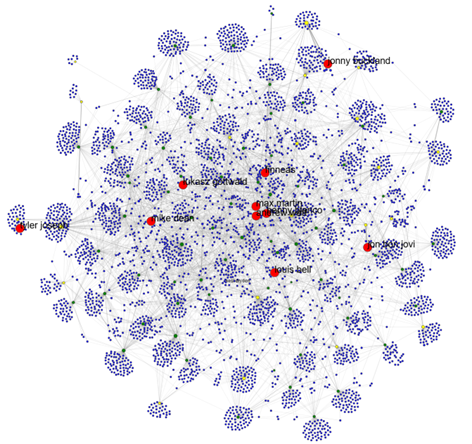

In [183]:
# Compute degree (number of connections per node)
degrees = [deg for _, deg in G.degree()]
weighted_degrees = [deg for _, deg in G.degree(weight='weight')]

# Compute statistics
degree_stats = {
    "average_degree": sum(degrees) / len(degrees),
    "median_degree": statistics.median(degrees),
    "mode_degree": statistics.mode(degrees) if len(set(degrees)) > 1 else "No mode",
    "min_degree": min(degrees),
    "max_degree": max(degrees)
}

weighted_degree_stats = {
    "average_weighted_degree": sum(weighted_degrees) / len(weighted_degrees),
    "median_weighted_degree": statistics.median(weighted_degrees),
    "mode_weighted_degree": statistics.mode(weighted_degrees) if len(set(weighted_degrees)) > 1 else "No mode",
    "min_weighted_degree": min(weighted_degrees),
    "max_weighted_degree": max(weighted_degrees)
}

# Print results
print("Degree Statistics:", degree_stats)
print("Weighted Degree Statistics:", weighted_degree_stats)

Degree Statistics: {'average_degree': 2.896461336828309, 'median_degree': 1.0, 'mode_degree': 1, 'min_degree': 0, 'max_degree': 165}
Weighted Degree Statistics: {'average_weighted_degree': 4.772389689820883, 'median_weighted_degree': 1.0, 'mode_weighted_degree': 1, 'min_weighted_degree': 0, 'max_weighted_degree': 283}


Our first network is constructed with artists or songwriters as the nodes and songs as the link between the nodes. To distinguish more easily between songwriter and artists we have colour-coded the graph so nodes that are purely songwriters are blue, and purely artists are yellow. We discovered, that a lot of artists are also credited as songwriters and these we made green. 
We highlighted the top 10 nodes of songwriters with the most links, which are the bigger red nodes. The network contains 4578 nodes for each unique artist or songwriter and 6630 links.  

Based on the numbers from the degree statistics, weighted degree statistics and from the visualization of the network we can see that the nodes form in a lot of big clusters centered around an artist. Most songwriters are connected to only one artist, as shown by the mode and median degree of 1 and the artists generally all have a lot of songwriters that are only connected to them. These single-link nodes tell us a lot about the music industry for the top artists, as it supports the idea that top artists often work with dedicated songwriting teams rather than widely shared contributors. It indicates that using songwriters is very common as each of these top artists seem to have their own team and also that high-profile artists tend to maintain exclusive collaborations with a select group of writers. This makes sense as we are looking at the most successful artists of the decade, who would certainly have the resources to keep such a team around themselves. 

An important observation is the significant difference between the lowest and highest degree values in the network. The minimum degree is 0, which is a source of error as all nodes should be connected to at least one other node due to the setup of the dataset. However, the maximum degree reaches 165, meaning one artists or songwriter has collaborated with 165 different individuals in the network. This max degree could belong to either a songwriter or a an artists, but we can look up the degree of the top 10 songwriters with the most connections: 

In [44]:
# Songwriters with the most links
top_songwriters

[('max martin', 106),
 ('benny blanco', 70),
 ('louis bell', 66),
 ('łukasz gottwald', 59),
 ('tyler joseph', 57),
 ('finneas', 53),
 ('jon bon jovi', 52),
 ('andrew watt', 46),
 ('mike dean', 46),
 ('jonny buckland', 45)]

Here we can see that there is a stark contrast between the highest and lowest amount of links for the songwriters, which highlights the uneven distribution of influence. The vast majority of songwriters are only connected to a single artist, while a small handful of highly connected individuals play a central and disproportionately influential role in shaping the music across multiple artists and genres.

These top 10 songwriters also share a lot of attributes. They are all producers, who work behind-the-scenes across a variety of genres. While some of them such as Pharrell Williams and Max Martin has appeared in the music industry for a long time other are more recent additions such as Finneas. 

#### Community detection

We use community detection on the graph to support our conclusions drawn from the previous graph. 

In [45]:
# Load the JSON file
with open("Songwriter_Artist_graph.json", "r") as f:
    data = json.load(f)

# Convert to NetworkX graph
G = json_graph.node_link_graph(data)

# Check edges
print(f"Initial nodes: {G.number_of_nodes()}")
print(f"Initial edges: {G.number_of_edges()}")

Initial nodes: 4578
Initial edges: 6630


In [ ]:
# Run Louvain on the song graph
partition = community_louvain.best_partition(G, weight='weight')

# Force all community IDs to int
partition = {node: int(group) for node, group in partition.items()}

In [ ]:
nx.set_node_attributes(G, partition, name='group')

In [ ]:
community_sizes = Counter(partition.values())

In [ ]:
num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")

Number of communities: 34


In [ ]:
netwulf.visualize(G)

(None, None)

Result of community detection:

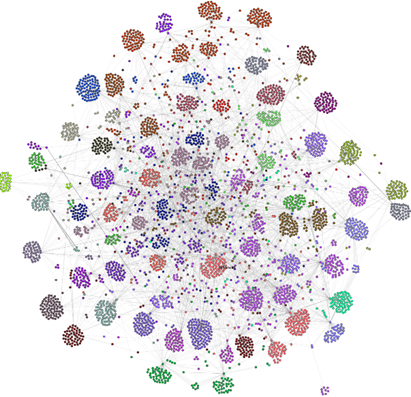

The conclusion from the previous graph is supported on this graph, when we use Louvain community detection on the network and colour seperate all the communities in the visualization. Here we can again see how the communities are formed around a central artist with the artists team of songwriters appearing as a cloud around them. 

In [281]:
# Size distribution
community_sizes = Counter(partition.values())
print("\nCommunity sizes:")
for cid, size in community_sizes.items():
    print(f"Community {cid}: {size} nodes")

# Density and centrality
for cid in community_sizes:
    nodes = [n for n in G.nodes if partition[n] == cid]
    subgraph = G.subgraph(nodes)

    density = nx.density(subgraph)
    print(f"\nCommunity {cid}:")
    print(f"- Density: {density:.3f}")

    centrality = nx.degree_centrality(subgraph)
    top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print("- Top central nodes:", [n for n, _ in top_nodes])




Community sizes:
Community 0: 37 nodes
Community 1: 2 nodes
Community 2: 10 nodes
Community 59: 60 nodes
Community 4: 9 nodes
Community 5: 65 nodes
Community 6: 97 nodes
Community 7: 3 nodes
Community 8: 8 nodes
Community 9: 40 nodes
Community 10: 61 nodes
Community 11: 2 nodes
Community 12: 2 nodes
Community 43: 48 nodes
Community 14: 26 nodes
Community 15: 2 nodes
Community 16: 35 nodes
Community 29: 67 nodes
Community 18: 6 nodes
Community 19: 2 nodes
Community 20: 21 nodes
Community 21: 2 nodes
Community 22: 2 nodes
Community 23: 2 nodes
Community 24: 42 nodes
Community 25: 3 nodes
Community 26: 25 nodes
Community 27: 5 nodes
Community 28: 3 nodes
Community 30: 2 nodes
Community 31: 15 nodes
Community 32: 3 nodes
Community 33: 36 nodes
Community 34: 2 nodes
Community 35: 2 nodes
Community 37: 45 nodes
Community 36: 89 nodes
Community 39: 31 nodes
Community 40: 4 nodes
Community 41: 5 nodes
Community 42: 4 nodes
Community 44: 5 nodes
Community 45: 3 nodes
Community 46: 7 nodes
Comm

Using the Louvain algorithm, we identified 34 distinct communities in our artist–songwriter network. These communities represent clusters of closely interconnected artists and songwriters—groups that collaborate frequently. The community sizes vary significantly, ranging from very small, tightly knit groups such as Community 33 with 11 nodes to much larger clusters like Community 14 with 439 nodes. This variation reflects the diversity in collaboration intensity and artistic reach among artists.

Most communities have moderately low density between 0.009–0.020, indicating that while nodes are clustered, not every artist collaborates with all others in their community. Community 14, which includes Nicki Minaj, Drake, and Cardi B, is the largest with 439 nodes but it has a very low density 0.005, suggesting a sprawling but loosely connected network. Possibly a reflection of the wide range of high-profile artists in hip hop and pop. In contrast, Community 33, which includes Mumford & Sons, has only 11 nodes but the highest density 0.182, reflecting a small, tightly collaborating circle, which is a pattern that is more often seen in niche or genre-specific groups like folk or indie.

The large, low-density communities often feature superstar artists with broad networks of collaborators Drake, Beyoncé, Kanye West. These artists might work with many different songwriters, but those writers may not collaborate with each other, resulting in lower internal density. The smaller, high-density communities more often represent bands or tightly-knit genre groups, where collaboration is more frequent and concentrated among the same members.

Additionally from the community coloured graph we can also more easily see that there exists a lot of floating nodes, which do not seem to be connected to only one of these songwriter clouds, which indicates that there is still a network of more collaborative songwriters being slightly blocked from view by the clouds of single-link songwriters. In order to bring this hidden structure more towards the surface we reduce the network. 

## **Reduced network Songwriter and artist network**

To try and determine the structure of the songwriters that are more collaborative and work with more than one artist, we remove all nodes with degree less than 2. 

In [ ]:
# Load the JSON file
with open("Songwriter_Artist_graph.json", "r") as f:
    data = json.load(f)

# Convert to NetworkX graph
G = json_graph.node_link_graph(data, edges="links")

Initial nodes: 4578
Initial edges: 6630


In [ ]:
# Extract largest connected component
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

# Compute strength (weighted degree)
strengths = dict(G_lcc.degree(weight='weight'))
nx.set_node_attributes(G_lcc, strengths, name='strength')
max_strength = max(strengths.values())

# Normalize roles: lowercase, strip
for node in G_lcc.nodes:
    roles = G_lcc.nodes[node].get('role', [])
    if isinstance(roles, list):
        G_lcc.nodes[node]['role'] = [r.strip().lower() for r in roles]

# Identify role groups
pure_songwriters = [
    node for node, data in G_lcc.nodes(data=True)
    if data.get('role') == ['songwriter']
]

pure_artists = [
    node for node, data in G_lcc.nodes(data=True)
    if data.get('role') == ['artist']
]

mixed_roles = [
    node for node, data in G_lcc.nodes(data=True)
    if isinstance(data.get('role'), list) and
       'artist' in data['role'] and 'songwriter' in data['role']
]

# Top 10 pure songwriters by strength
top_songwriters = sorted(
    [(node, strengths[node]) for node in pure_songwriters],
    key=lambda x: x[1],
    reverse=True
)[:10]
top_songwriter_nodes = set(node for node, _ in top_songwriters)

# Style nodes: color, size, label
for node in G_lcc.nodes:
    roles = G_lcc.nodes[node].get('role', [])
    strength = strengths.get(node, 1)
    base_size = 20 + (strength / max_strength) * 80

    if node in top_songwriter_nodes:
        G_lcc.nodes[node]['color'] = 'red'
        G_lcc.nodes[node]['size'] = 500
        G_lcc.nodes[node]['label'] = node
    elif node in pure_songwriters:
        G_lcc.nodes[node]['color'] = 'blue'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    elif node in pure_artists:
        G_lcc.nodes[node]['color'] = 'yellow'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    elif node in mixed_roles:
        G_lcc.nodes[node]['color'] = 'green'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    else:
        G_lcc.nodes[node]['color'] = 'gray'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""

# Find nodes with degree 1
nodes_to_remove = [node for node, degree in G_lcc.degree() if degree < 2 ]

# Remove them
G_lcc.remove_nodes_from(nodes_to_remove)


# Visualize
netwulf.visualize(G_lcc)


(None, None)

Result of reduced network: 

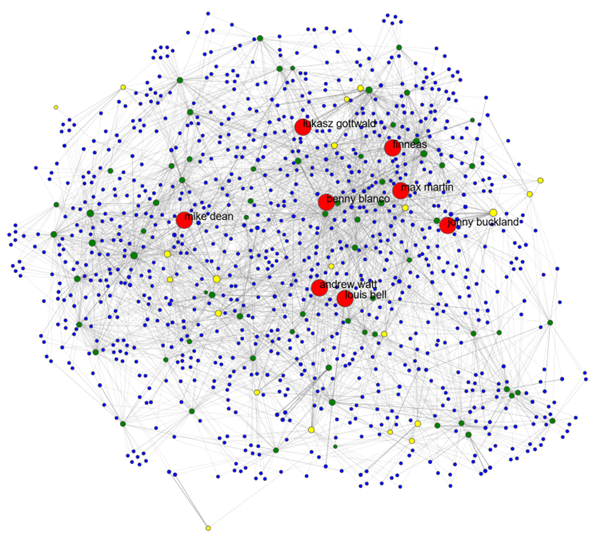

The reduced graph is much more sparse and spread out compared to the full network and it is more difficult to determine any communities or general trends in the collaboration of the songwriters and artists. Therefore the community detection is very necessary in this case.

#### Community detection

In [186]:
# Load the JSON file
with open("Songwriter_Artist_graph.json", "r") as f:
    data = json.load(f)

# Convert to NetworkX graph
G = json_graph.node_link_graph(data, edges="links")

# Check edges
print(f"Initial nodes: {G.number_of_nodes()}")
print(f"Initial edges: {G.number_of_edges()}")

# Debug: show low-degree nodes
low_degree_nodes = [n for n, d in G.degree() if d < 2]
print(f"Nodes with degree < 2: {len(low_degree_nodes)}")

# Remove them
G.remove_nodes_from(low_degree_nodes)

# Final count
print(f"Remaining nodes: {G.number_of_nodes()}")
print(f"Remaining edges: {G.number_of_edges()}")

Initial nodes: 4578
Initial edges: 6630
Nodes with degree < 2: 3510
Remaining nodes: 1068
Remaining edges: 3121


In [187]:
# Run Louvain on the song graph
partition = community_louvain.best_partition(G, weight='weight')

# Force all community IDs to int
partition = {node: int(group) for node, group in partition.items()}

In [188]:
nx.set_node_attributes(G, partition, name='group')
community_sizes = Counter(partition.values())

In [191]:
network, config = netwulf.visualize(G)

Result of community detection:

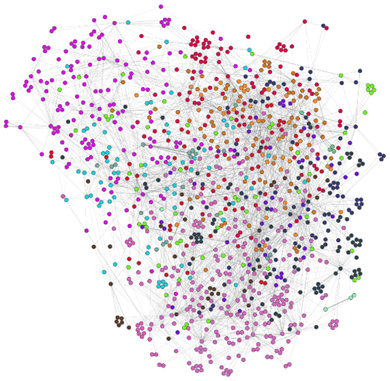 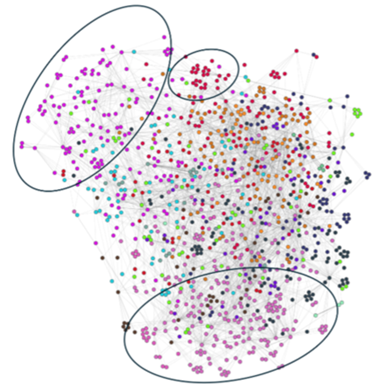

We colour the communities created by the Louvain algorithm and immediatly we can see 3 pretty bigger clusters as circled on the second image above. If we look more closely there also seem to be a turqois and orange cluster as circled in yellow below. Where the orange cluster is closely intertwened with the red. 

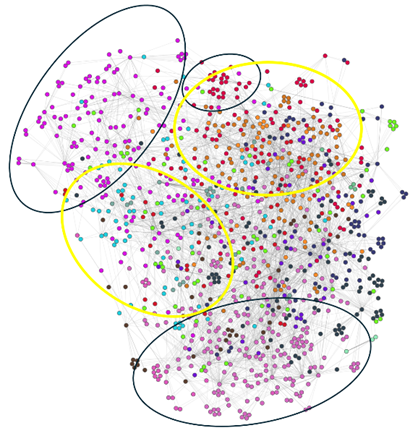

The large ellipse encircle large, populated communities representing more mainstream and high-output clusters such pop or hip-hop megastars with many collaborators. Whereas the smaller ellipse enclose smaller, tighter communities, which could potentially be because they represent more genre-specific niches or band-focused songwriting teams. 

In the middle of the graph there is a lot of mixing of the different nodes, where some nodes are positioned between major clusters, which suggest they may act as bridges or connectors between communities. These could be versatile songwriters or cross-genre artists collaborating with multiple teams. Their presence indicates that influence can span across stylistic boundaries in the industry.

In [52]:
# Size distribution
community_sizes = Counter(partition.values())
print("\nCommunity sizes:")
for cid, size in community_sizes.items():
    print(f"Community {cid}: {size} nodes")

# Density and centrality
for cid in community_sizes:
    nodes = [n for n in G.nodes if partition[n] == cid]
    subgraph = G.subgraph(nodes)

    density = nx.density(subgraph)
    print(f"\nCommunity {cid}:")
    print(f"- Density: {density:.3f}")

    centrality = nx.degree_centrality(subgraph)
    top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print("- Top central nodes:", [n for n, _ in top_nodes])




Community sizes:
Community 0: 18 nodes
Community 6: 39 nodes
Community 16: 83 nodes
Community 9: 23 nodes
Community 4: 180 nodes
Community 10: 79 nodes
Community 15: 43 nodes
Community 7: 39 nodes
Community 14: 89 nodes
Community 1: 118 nodes
Community 8: 100 nodes
Community 13: 54 nodes
Community 11: 40 nodes
Community 2: 47 nodes
Community 17: 62 nodes
Community 12: 37 nodes
Community 3: 13 nodes
Community 5: 4 nodes

Community 0:
- Density: 0.144
- Top central nodes: ['the chainsmokers', 'coldplay', 'will champion']

Community 6:
- Density: 0.058
- Top central nodes: ['xxxtentacion', 'onerepublic', 'paul mccartney']

Community 16:
- Density: 0.032
- Top central nodes: ['camila cabello', 'miley cyrus', 'juice wrld']

Community 9:
- Density: 0.095
- Top central nodes: ['ed sheeran', 'taylor swift', 'lorde']

Community 4:
- Density: 0.024
- Top central nodes: ['travis scott', 'drake', 'cardi b']

Community 10:
- Density: 0.034
- Top central nodes: ['pitbull', 'flo rida', 'david guetta

The Louvain algorithm revealed 18 distinct communities in this network, each representing a group of artists and songwriters who are more densely connected to each other than to those outside their group. These communities range from very small to relatively large, and the density values show meaningful differences in how tightly these communities collaborate.

Some communities of the communities reflect genre proximity: 

1. Community 1: Country artists like Blake Shelton and Jason Aldean

2. Community 2: Hip-hop/R&B crossover with Jay Z and Beyoncé

3. Community 11: Mainstream pop with Bruno Mars and Justin Timberlake

4. Community 13: Pop/R&B with Khalid and Rihanna

This genre-based clustering suggests that songwriter usage often aligns with genre. 


## **Songs and Songwriters Network**

Besides the Songwriter and Artists graph we also construct a network of the relationship between songs and songwriters. Here the songs are nodes with attributes such as popularity and release year added, where the links are shared songswriters between songs. 

#### Creating network

In [58]:
df = pd.read_csv("final_dataset_cleaned.csv")
df['All_contributors'] = df.apply(lambda row: [row['Artist'],row['songwriters']], axis=1)
df.head(4)

Artist                      name  \
0  the chainsmokers  Something Just Like This   
1  the chainsmokers                     Paris   
2  the chainsmokers              This Feeling   
3  the chainsmokers                    Jungle   

                                        artists  popularity  duration_ms  \
0              ['the chainsmokers', 'coldplay']        90.0     247160.0   
1                          ['the chainsmokers']        82.0     221506.0   
2      ['the chainsmokers', 'kelsea ballerini']        74.0     197946.0   
3  ['alok', 'the chainsmokers', 'mae stephens']        74.0     175500.0   

   release_year                                        songwriters  \
0          2017  ['jonny buckland', 'will champion', 'chris mar...   
1          2017                           ['elijah the alchemist']   
2          2018    ['travis barker', 'tom delonge', 'mark hoppus']   
3          2023                       ['the motels', 'the motels']   

                                              lyrics  \
0  I've been reading books of old, the legends an...   
1  We were stayin' in Paris\nTo get away from you...   
2  I'll tell you a story before it tells itself\n...   
3  I'm out, feeling lonely again\nAm I too scared...   

                                    All_contributors  
0  [the chainsmokers, ['jonny buckland', 'will ch...  
1       [the chainsmokers, ['elijah the alchemist']]  
2  [the chainsmokers, ['travis barker', 'tom delo...  
3   [the chainsmokers, ['the motels', 'the motels']]

In [63]:
# Change strings to lists
df['songwriters'] = df['songwriters'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

#Remove main artist as a songwriter
df['songwriters'] = df.apply(
    lambda row: [sw for sw in row['songwriters'] if sw != row['Artist']],
    axis=1
)

In [80]:
# Initialize graph + add song nodes
G = nx.Graph()
for song in df['name']:
    G.add_node(song)

#Build dictinoary of songs and songwriters
songwriter_to_songs = defaultdict(set)

for _, row in tqdm(df.iterrows(), total=len(df), desc="Indexing songwriters"):
    song = row['name']
    for writer in row['songwriters']:
        songwriter_to_songs[writer].add(song)

#Create edges between songs with shared songwriters
for songwriter, songs in tqdm(songwriter_to_songs.items(), desc="Creating song links"):
    for song1, song2 in combinations(songs, 2):
        if G.has_edge(song1, song2):
            G[song1][song2]['weight'] += 1
        else:
            G.add_edge(song1, song2, weight=1)

#Add attributes like release_year and popularity to each node
for _, row in df.iterrows():
    song = row['name']
    if G.has_node(song):
        G.nodes[song]['release_year'] = row['release_year']
        G.nodes[song]['popularity'] = row['popularity']



Creating song links: 100%|██████████| 4547/4547 [00:00<00:00, 98385.31it/s]


In [81]:
# Save graph as JSON
graph_data = nx.node_link_data(G)

with open("Songwriter_Song.json", "w") as f:
    json.dump(graph_data, f, indent=4)

#### Load graph and colour the nodes based on popularity

In [196]:
# Load the JSON file
with open("Songwriter_Song.json", "r") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data)

c:\Users\celin\miniconda3\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [197]:
#Colour nodes based on popularity
for node in G.nodes:
    pop = G.nodes[node].get('popularity', 0)

    if isinstance(pop, (int, float)):  # Ensure it's a number
        if pop >= 90:
            G.nodes[node]['color'] = 'red'
        elif pop >= 80:
            G.nodes[node]['color'] = 'blue'
        elif pop >= 70:
            G.nodes[node]['color'] = 'green'
        elif pop >= 60:
            G.nodes[node]['color'] = 'orange'
        else:
            G.nodes[node]['color'] = 'gray'
    else:
        G.nodes[node]['color'] = 'gray'

In [84]:
netwulf.visualize(G)

(None, None)

Result of visualization: 

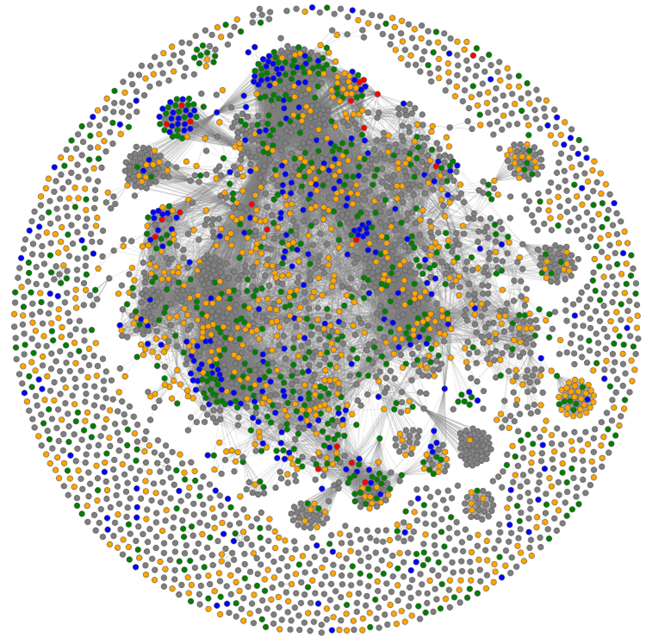

#### Network statistics

In [198]:
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 3511, Edges: 37714


In [199]:
# Count how many songs each songwriter has worked on
num_songs_per_writer = [len(songs) for songs in songwriter_to_songs.values()]
multi_song_writers = sum(1 for count in num_songs_per_writer if count > 1)

print("Total amount of songwriters: " + str(len(num_songs_per_writer)))
print(f"{multi_song_writers} songwriters worked on more than 1 song.")

Total amount of songwriters: 4547
1305 songwriters worked on more than 1 song.


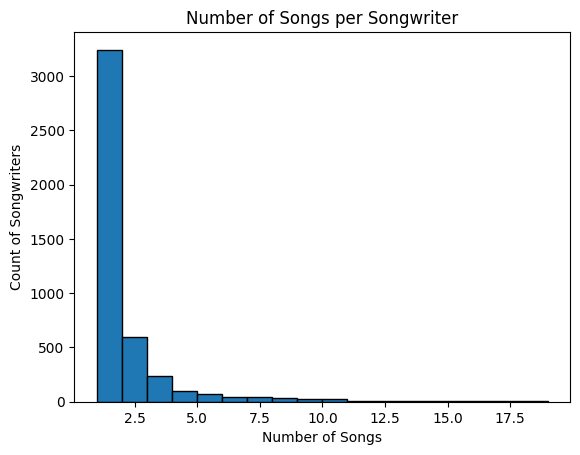

In [200]:
plt.hist(num_songs_per_writer, bins=range(1, 20), edgecolor='black')
plt.title("Number of Songs per Songwriter")
plt.xlabel("Number of Songs")
plt.ylabel("Count of Songwriters")
plt.show()

In [201]:
# Compute degree (number of connections per node)
degrees = [deg for _, deg in G.degree()]
weighted_degrees = [deg for _, deg in G.degree(weight='weight')]

# Compute statistics
degree_stats = {
    "average_degree": sum(degrees) / len(degrees),
    "median_degree": statistics.median(degrees),
    "mode_degree": statistics.mode(degrees) if len(set(degrees)) > 1 else "No mode",
    "min_degree": min(degrees),
    "max_degree": max(degrees)
}

weighted_degree_stats = {
    "average_weighted_degree": sum(weighted_degrees) / len(weighted_degrees),
    "median_weighted_degree": statistics.median(weighted_degrees),
    "mode_weighted_degree": statistics.mode(weighted_degrees) if len(set(weighted_degrees)) > 1 else "No mode",
    "min_weighted_degree": min(weighted_degrees),
    "max_weighted_degree": max(weighted_degrees)
}

# Print results
print("Degree Statistics:", degree_stats)
print("Weighted Degree Statistics:", weighted_degree_stats)

Degree Statistics: {'average_degree': 21.483338080318997, 'median_degree': 6, 'mode_degree': 0, 'min_degree': 0, 'max_degree': 213}
Weighted Degree Statistics: {'average_weighted_degree': 28.81344346340074, 'median_weighted_degree': 8, 'mode_weighted_degree': 0, 'min_weighted_degree': 0, 'max_weighted_degree': 373}


The graph visualizes the relationship between songs based on their shared songwriters and it contains 3511 nodes and 37714 egdes. 
The core of the graph includes a tightly interconnected mass of songs, suggesting these songs were written by a network of commonly used or highly collaborative songwriters. Meanwhile, many songs also remain on the fringes, indicating independent creative processes with only one songwriter. The analysis of the network shows that out of the 4547 songwriters only 1305 worked on more than one song. After that first song the number of songs that each songwriters work on also drop drastically as seen in the histogram above, suggesting that it is a smaller group of songwriters binding the songs in the center together. 

**Graph statistics:**

The graph relects the dual-nature of writing songs, where there exist a lot of songs written solely by one unique songwriter, who is not used on any other songs as seen by the graphs min degree of 0. The reason that a lot of songwriters are only included on one specific song could be that they are only there to add a special expertise or talent. 

The median of 6 and mode of 0 also show that a large number of songs are only weakly connected or not connected at all. This again highlights the asymmetry in the songwriting landscape. Most songs are written by small, non-overlapping teams, while a small subset of songs are connected to many others through highly prolific songwriters. The maximum degree of 213 is substantial as it indicates that one song shares writers with over 200 other songs. This likely reflects involvement of superstar songwriters who have contributed to a wide range of chart-topping hits.

The higher average weighted degree compared to the unweighted version suggests that many song connections are strengthened by multiple shared contributors, not just a single co-writer. Combined with a maximum weighted degree of 373 it implies an extremely strong level of collaboration overlap for certain songs. This could partially be because of albums where many songs were shaped by the same small group of contributors.


**Popularity:** 

The nodes in the network have been color-coded based on their popularity scores. However, upon visual inspection, there does not appear to be a clear or consistent pattern where specific communities show significantly higher or lower popularity on average. Popularity seems to be evenly distributed across the network, with both high- and low-popularity nodes present in most communities.

This suggests that popularity is not tightly correlated with community structure in this network. In other words, songs with high popularity are not concentrated within a few elite communities but are instead spread across various clusters. This may indicate that influence or success in the music industry is not solely determined by the artists collaborative circle, but perhaps also by individual reach, genre, or external factors not captured in the collaboration structure alone.

#### Community detection

To support the analysis above we use the Louvain algorithm to compute and seperate the graph into clear communities. 

In [85]:
# Load the JSON file
with open("Songwriter_Song.json", "r") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data)

In [ ]:
# Run Louvain on the graph
partition = community_louvain.best_partition(G, weight='weight')

In [87]:
nx.set_node_attributes(G, partition, name='group')

In [88]:
community_sizes = Counter(partition.values())
print(community_sizes.most_common(5))

[(11, 267), (50, 231), (5, 207), (67, 193), (2, 170)]


In [89]:
num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")

Number of communities: 1174


In [91]:
netwulf.visualize(G)

(None, None)

Result of vizualization: 

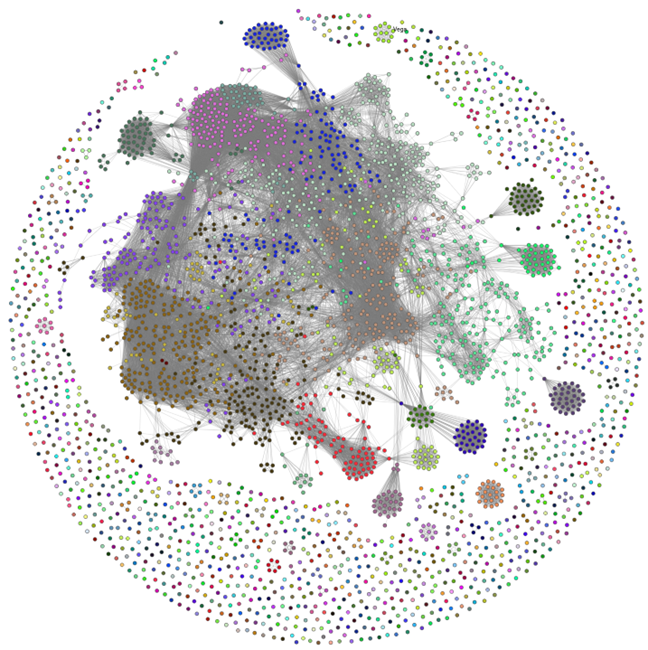

The community coloured graph above supports the previous statement and analysis where the outer fringe is made up of a lot of singular communities which contains only one song that is associated with a singular, unique songwriter. Additionally, from this graph we can see that the songs towards the center have been seperated into more prominent communties, where the graph illustrates that there exists influential songwriters who bridge the gaps between these communities. 

#### **Reduced Song and songwriter network**

Like with the Songwriters and Artist graph we reduce the network to look at the nodes with the most links as these represent the songs of the most collaborative artists in order to research the structure behind. Here we remove any nodes with degree less than 2. 

In [98]:
# Load the JSON file
with open("Songwriter_Song.json", "r") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data)

In [99]:
#Colour nodes based on popularity
for node in G.nodes:
    pop = G.nodes[node].get('popularity', 0)

    if isinstance(pop, (int, float)):  # Ensure it's a number
        if pop >= 90:
            G.nodes[node]['color'] = 'red'
        elif pop >= 80:
            G.nodes[node]['color'] = 'blue'
        elif pop >= 70:
            G.nodes[node]['color'] = 'green'
        elif pop >= 60:
            G.nodes[node]['color'] = 'orange'
        else:
            G.nodes[node]['color'] = 'gray'
    else:
        G.nodes[node]['color'] = 'gray'

In [100]:
G_filtered = G.edge_subgraph([
    (u, v) for u, v, d in G.edges(data=True) if d['weight'] >= 2
]).copy()

print(f"Filtered graph: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")


Filtered graph: 1495 nodes, 8263 edges


In [101]:
netwulf.visualize(G_filtered)

(None, None)

Result of filterede network visulization: 

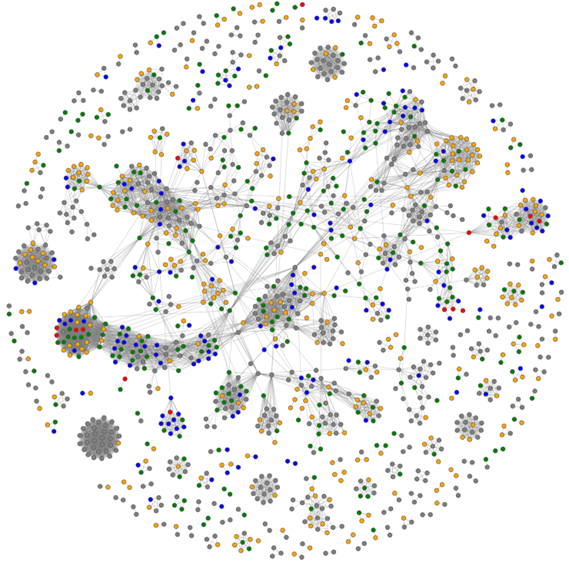

This graph retains many of the core structural elements seen in the full network, but with a noticeably smaller central hub of interconnected songs and a greater number of smaller clusters, typically consisting of 1–10 songs. Unlike with the full network we can observe that a few of the bigger clusters contains a higher concentration of songs with a high popularity score. This suggests that there actually are certain influential songwriters operating within these clusters and contributing to producing the greatist hits for the top artists that we see. Confirming the often unseen influence of elite songwriters in shaping the success of top-charting artists.

#### Community detection

In [202]:
# Load the JSON file
with open("Songwriter_Song.json", "r") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data)

In [203]:
G_filtered = G.edge_subgraph([
    (u, v) for u, v, d in G.edges(data=True) if d['weight'] >= 2
]).copy()

print(f"Filtered graph: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")


Filtered graph: 1495 nodes, 8263 edges


In [204]:
# Run Louvain on the song graph
partition = community_louvain.best_partition(G_filtered, weight='weight')

In [205]:
nx.set_node_attributes(G_filtered, partition, name='group')

In [206]:
community_sizes = Counter(partition.values())
print(community_sizes.most_common(5))

[(6, 92), (38, 91), (5, 65), (17, 65), (10, 62)]


In [207]:
num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")

Number of communities: 193


In [212]:
netwulf.visualize(G_filtered)

(None, None)

Result of community visualization:

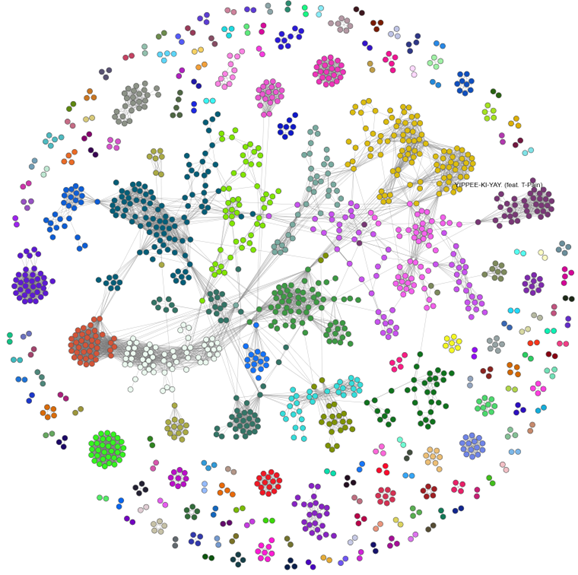

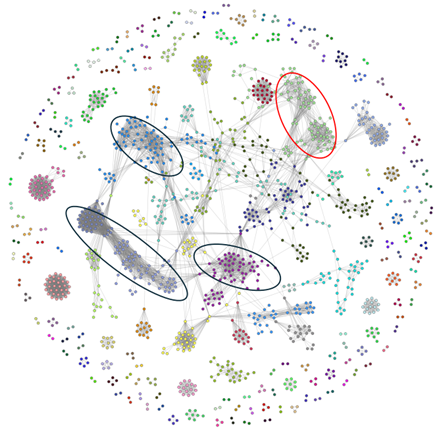

We ran communtity detection on the reduced graph to highlight the clusters even though they were pretty clear from the popularity coloured graph. Here we notice 3 big main communities and by looking at the songs contained in these communities, we could determine that the 3 communities encircled in black appear to be mainly popsongs, whereas the red ellipse is circling a cluster of rapsongs. The 3 pop clusters are connected to the rap cluster by cross-collaborating songwriters, which aligns with the fact that rapartists often feature on popsongs. 

It is also interesting to note that there seems to be 3 main songwriting teams in the genre of pop as represented through the 3 pop clusters, where the pop clusters do collaborate across the community borders but still mainly stay with their own team enough for it to be detectable. 

## Dataset analysis

In this section we dive further into the structure we discovered through the networks and look more closely at the actual most influential of the songwriters. We extract tables through data analysis directly of the dataset. First, we have constructed 3 tables which give us information on how artists use songwriters by computing the artists with the most songwriters in common and also the artists with both the most and the least songwriters.  

In [284]:
df = pd.read_csv("final_dataset.csv")

In [297]:
def safe_parse_writers(entry):
    if isinstance(entry, list):
        return entry
    if isinstance(entry, str):
        try:
            return ast.literal_eval(entry)
        except:
            return []
    return []

df['songwriters'] = df['songwriters'].apply(safe_parse_writers)

In [298]:
# Mapping from artist → set of songwriters
artist_to_writers = defaultdict(set)

for _, row in df.iterrows():
    artist = row['Artist']
    for writer in row['songwriters']:
        artist_to_writers[artist].add(writer)

# Compare all artist pairs for shared songwriters
pair_shared_count = Counter()

artists = list(artist_to_writers.keys())
for a1, a2 in combinations(artists, 2):
    shared = artist_to_writers[a1].intersection(artist_to_writers[a2])
    if shared:
        pair_shared_count[(a1, a2)] = len(shared)

# Show top 10 pairs with most shared songwriters
print("Top 10 artist pairs with most shared songwriters:")
for (a1, a2), count in pair_shared_count.most_common(10):
    print(f"{a1} & {a2} → {count} shared songwriters")


Top 10 artist pairs with most shared songwriters:
pentatonix & camila cabello → 22 shared songwriters
camila cabello & selena gomez → 21 shared songwriters
meek mill & travis scott → 18 shared songwriters
cardi b & drake → 18 shared songwriters
kanye west & trey songz → 17 shared songwriters
miley cyrus & camila cabello → 16 shared songwriters
migos & travis scott → 16 shared songwriters
travis scott & nicki minaj → 16 shared songwriters
meek mill & cardi b → 15 shared songwriters
travis scott & drake → 15 shared songwriters


This first table indicates that there exist two subsgroups which share songwriters – the first group being Travis Scott, Cardi B, Drake, Nicki Minaj and Meek Mill and the second group being Camila Cabello, Miley Cyrus and Selena Gomez. The first group is composed of rappers while the main group is primarily based in the pop genre, so here there is a clear separation and indication of songwriters connecting the artists belonging to similar categories. 

In [299]:
def shared_songwriters_among(artist_list, artist_to_writers):
    if len(artist_list) < 2:
        return set()

    shared = artist_to_writers[artist_list[0]]
    for artist in artist_list[1:]:
        shared = shared.intersection(artist_to_writers[artist])
    
    return shared

In [300]:
artists_input = ["selena gomez","camila cabello","miley cyrus"]
# Get shared songwriters
common_writers = shared_songwriters_among(artists_input, artist_to_writers)

print(f"Shared songwriters among {', '.join(artists_input)}:")
print(common_writers)

artists_input = ["selena gomez","camila cabello"]

# Get shared songwriters
common_writers = shared_songwriters_among(artists_input, artist_to_writers)

print(f"Shared songwriters among {', '.join(artists_input)}:")
print(common_writers)


Shared songwriters among selena gomez, camila cabello, miley cyrus:
{'justin tranter', 'louis bell', 'andrew watt', 'ali tamposi', 'jon bellion'}
Shared songwriters among selena gomez, camila cabello:
{'benny blanco', 'mike sabath', 'joe khajadourian', 'gucci mane', 'charli xcx', 'louis bell', 'andrew watt', 'jon bellion', 'ali tamposi', 'mattias larsson', 'justin tranter', 'alex schwartz', 'mikkel storleer eriksen', 'jordan johnson', 'madison love', 'stefan johnson', 'robin fredriksson', 'tor erik hermansen', 'cashmere cat', 'finneas', 'brian lee'}


For Camilla Cabello, Miley Curys and Selena Gomez we can see 3 of the biggest songwriters - Louis Bell, Andrew Watt and Ali Tamposi are shared between them. Between just Camilla Cabello and Selena Gomez we additionally see Benny Blanco and Finneas. 

In [303]:
artists_input = ["travis scott", "cardi b"]

# Get shared songwriters
common_writers = shared_songwriters_among(artists_input, artist_to_writers)

print(f"Shared songwriters among {', '.join(artists_input)}:")
print(common_writers)

artists_input = ["travis scott", "meek mill"]

# Get shared songwriters
common_writers = shared_songwriters_among(artists_input, artist_to_writers)

print(f"Shared songwriters among {', '.join(artists_input)}:")
print(common_writers)


Shared songwriters among travis scott, cardi b:
{'21 savage', 'vinylz', 'noah goldstein', '30 roc', 'kevin gomringer', 'tay keith', 'allen ritter', 'tim gomringer', 'frank dukes', 'sza', 'rosalía', 'murda beatz', 'boi‐1da', 'ye'}
Shared songwriters among travis scott, meek mill:
{'21 savage', 'vinylz', '30 roc', 'hit‐boy', 'kevin gomringer', 'the notorious b.i.g.', 'tay keith', 'drake', 'pharrell williams', 'oz', 'tim gomringer', 'lil baby', 'young thug', 'mike dean', 'metro boomin', 'future', 'wheezy', 'ye'}


Travis Scott and Cardi B share multiple songwriters but none that appear as the 10 most popular songwriters. Meek Mill and Travis share 18 and only 1 is also one of the top 10 with the highest degree.

##### Number of songwriters used

In [266]:
# Count number of songwriters per artist
artist_writer_counts = {artist: len(writers) for artist, writers in artist_to_writers.items()}

In [267]:
# Sort and show lowest 10
lowest = sorted(artist_writer_counts.items(), key=lambda x: x[1])[:10]

print("Top 10 artists with fewest songwriters:")
for artist, count in lowest:
    print(f"{artist} → {count} songwriter(s)")


Top 10 artists with fewest songwriters:
paul mccartney → 4 songwriter(s)
billie eilish → 6 songwriter(s)
b.o.b → 9 songwriter(s)
lorde → 13 songwriter(s)
chris stapleton → 13 songwriter(s)
the rolling stones → 13 songwriter(s)
bon jovi → 17 songwriter(s)
mumford & sons → 20 songwriter(s)
taylor swift → 23 songwriter(s)
sia → 28 songwriter(s)


In [268]:
#Sort and show highest 10
highest = sorted(artist_writer_counts.items(), key=lambda x: x[1])[-10:]

print("Top 10 artists with the most songwriters:")
for artist, count in highest:
    print(f"{artist} → {count} songwriter(s)")

Top 10 artists with the most songwriters:
trey songz → 113 songwriter(s)
camila cabello → 113 songwriter(s)
pitbull → 115 songwriter(s)
cardi b → 117 songwriter(s)
flo rida → 123 songwriter(s)
nicki minaj → 124 songwriter(s)
pentatonix → 128 songwriter(s)
kanye west → 145 songwriter(s)
beyonce → 149 songwriter(s)
travis scott → 158 songwriter(s)


We follow the first table of most shared songwriters with two tables about which artists use the most and least songwriters, where we see a lot of the same artists from the first table repeated in the table for artists with the most songwriters. It seems that these artists are not creating their own songs as they have a big team of songwriters at their side. It makes sense that if we should be able to see shared semantic themes in the lyrics it would in the songs from these artists. Therefore, we focus some of the semantic analysis on here. 

##### Songwriter collaborations

In [269]:
df_exploded = df.explode('songwriters').reset_index(drop=True)

In [270]:
def normalize_name(name):
    if not isinstance(name, str):
        return ''
    name = unicodedata.normalize('NFKD', name)  # fix invisible unicode chars
    name = name.lower()
    name = name.replace('‐', '-').replace('–', '-').replace('—', '-')  # common hyphen variants
    name = name.strip()
    return name


In [273]:
# Normalize the 'songwriters' column
df_exploded['songwriters'] = df_exploded['songwriters'].apply(normalize_name)

# Remove any variation of 'jay-z'
df_exploded = df_exploded[~df_exploded['songwriters'].isin(['jay-z'])]
df_exploded = df_exploded[~df_exploded['songwriters'].isin(['ye'])]
df_exploded = df_exploded[~df_exploded['songwriters'].isin(['zac brown'])]
df_exploded = df_exploded[~df_exploded['songwriters'].isin(['bob marley'])]
df_exploded = df_exploded[~df_exploded['songwriters'].isin(['drake'])]


# Remove empty string songwriters
df_exploded = df_exploded[df_exploded['songwriters'].str.strip() != '']

In [274]:
df_filtered = df_exploded[df_exploded['songwriters'] != df_exploded['Artist']]

songwriter_collabs = (
    df_filtered.groupby('songwriters')['Artist']
    .nunique()
    .reset_index()
    .rename(columns={'Artist': 'num_unique_artists'})
    .sort_values(by='num_unique_artists', ascending=False)
)

# Display top songwriters
print(songwriter_collabs.head(10))


            songwriters  num_unique_artists
3339  pharrell williams                  19
3694        ryan tedder                  18
401        benny blanco                  17
2875         max martin                  17
214         andrew watt                  17
2630         louis bell                  15
2265                jr.                  14
2312     justin tranter                  13
3761      savan kotecha                  13
145         ali tamposi                  13


In [275]:
df_filtered = df_exploded[df_exploded['songwriters'] != df_exploded['Artist']]

# Count total collaborations per songwriter
songwriter_total_collabs = (
    df_filtered['songwriters']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'songwriter', 'songwriter': 'total_collaborations'})
)

print(songwriter_total_collabs.head(10))

       songwriters  count
0       max martin    106
1     benny blanco     70
2       louis bell     66
3  łukasz gottwald     59
4     tyler joseph     57
5          finneas     53
6     jon bon jovi     52
7        mike dean     46
8      andrew watt     46
9    jack antonoff     45


We also examined the top 10 songwriters to assess their reach and influence by calculating two key metrics: the number of unique artists each has collaborated with and their total number of collaborations. The first table above show that each songwriter has worked with between 13 and 19 different artists. Considering that our dataset includes only 100 of the most prominent artists from the 2010s, this is a substantial number. 

The second table above ranks the songwriters by the number of songs they contributed to. Leading the list is Max Martin with 106 songs, followed by Benny Blanco (70) and Louis Bell (66). These figures underscore the immense impact that a handful of songwriters have had on shaping mainstream music in the 2010s. Notably, all individuals on the list have contributed to at least 45 songs, emphasizing their consistent presence behind many of the decade's biggest hits. The data reflects how a relatively small group of influential writers have helped define the sound and success of the top artists of the era.

##### Songwriters yearly influence

In [276]:
top_10_songwriters = songwriter_total_collabs['songwriters'].head(10).tolist()
df_top10 = df_exploded[df_exploded['songwriters'].isin(top_10_songwriters)]

In [277]:
yearly_influence = (
    df_top10
    .groupby(['songwriters', 'release_year'])['Artist']
    .nunique()
    .reset_index(name='unique_artists')
)

In [278]:
influence_table = yearly_influence.pivot(
    index='songwriters', 
    columns='release_year', 
    values='unique_artists'
).fillna(0).astype(int)

influence_table

release_year     1984  1985  1986  1988  1992  1995  1999  2000  2001  2002  \
songwriters                                                                   
andrew watt         0     0     0     0     0     0     0     0     0     0   
benny blanco        0     0     0     0     0     0     0     0     0     0   
finneas             0     0     0     0     0     0     0     0     0     0   
jack antonoff       0     0     0     0     0     0     0     0     0     0   
jon bon jovi        1     1     1     1     1     1     0     1     0     1   
louis bell          0     0     0     0     0     0     0     0     0     0   
max martin          0     0     0     0     0     0     1     2     1     0   
mike dean           0     0     0     0     0     0     0     1     0     0   
tyler joseph        0     0     0     0     0     0     0     0     0     0   
łukasz gottwald     0     0     0     0     0     0     0     0     0     0   

release_year     ...  2016  2017  2018  2019  2020  2021  2022  2023  2024  \
songwriters      ...                                                         
andrew watt      ...     1     1     5     5     4     1     1     0     1   
benny blanco     ...     0     2     3     4     1     0     0     1     1   
finneas          ...     1     1     1     2     2     1     2     1     1   
jack antonoff    ...     2     3     0     1     0     2     0     1     2   
jon bon jovi     ...     0     0     1     0     0     0     0     0     1   
louis bell       ...     1     1     4     4     4     1     1     0     3   
max martin       ...     2     2     1     2     2     1     2     1     4   
mike dean        ...     3     0     1     1     0     1     1     3     1   
tyler joseph     ...     1     0     1     0     0     0     0     0     1   
łukasz gottwald  ...     1     1     0     0     1     0     1     1     1   

release_year     2025  
songwriters            
andrew watt         1  
benny blanco        1  
finneas             1  
jack antonoff       0  
jon bon jovi        0  
louis bell          0  
max martin          2  
mike dean           0  
tyler joseph        0  
łukasz gottwald     0  

[10 rows x 31 columns]

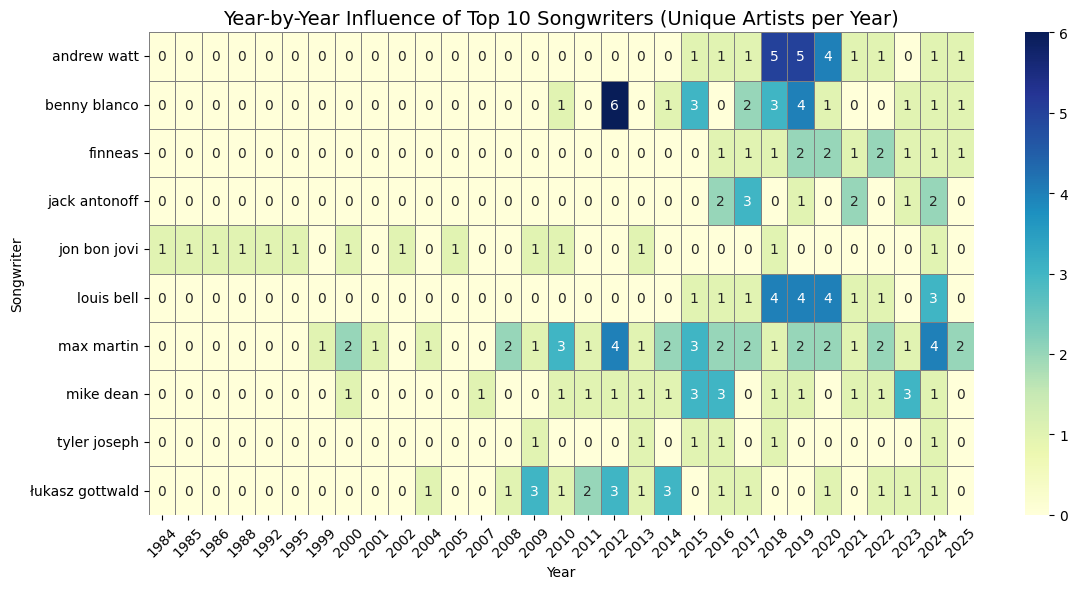

In [279]:
# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(influence_table, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('Year-by-Year Influence of Top 10 Songwriters (Unique Artists per Year)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Songwriter')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The heatmap above illustrates the year-by-year influence of the top 10 songwriters based on the number of unique top artists they collaborated with each year. It is evident that while some songwriters like Max Martin have had sustained influence over two decades, others such as Benny Blanco, Andrew Watt, and Louis Bell show more concentrated bursts of activity, particularly during the mid to late 2010s. The heatmap also highlights that many of these songwriters were consistently working with multiple top artists per year, underlining their central role in shaping mainstream music trends over time. Peaks in activity for Benny Blanco in 2010 and Andrew Watt in 2018 suggest periods where they were especially dominant in the industry.

##### Songwriters popularity 


In [280]:
# Group by songwriter and calculate average song popularity
popularity_ranking = (
    df_top10.groupby('songwriters')['popularity']
    .mean()
    .reset_index()
    .sort_values(by='popularity', ascending=False)
    .rename(columns={'popularity': 'average_popularity'})
)

# Add a ranking column
popularity_ranking['rank'] = range(1, len(popularity_ranking) + 1)
print(popularity_ranking[['rank', 'songwriters', 'average_popularity']].to_string(index=False))


 rank     songwriters  average_popularity
    1         finneas           76.433962
    2   jack antonoff           71.666667
    3       mike dean           70.608696
    4     andrew watt           70.282609
    5      max martin           69.122642
    6    tyler joseph           67.456140
    7      louis bell           67.393939
    8    benny blanco           64.800000
    9 łukasz gottwald           61.000000
   10    jon bon jovi           55.211538


In this ranking of the top 10 songwriters by average song popularity, Finneas emerges as the clear leader with an impressive score of 76.4, reflecting the immense success of his work, which is primarily in collaboration with his sister Billie Eilish. Interestingly he does not appear on the list of songwriters with the most unique artist collaborations but is present on the list with the most collaborations and here with a very high popularity score. This indicates that he is a main driving force behind the global phenomenon of Billie Ellish. 

Jack Antonoff and Mike Dean follow Finneas with high averages of 71.7 and 70.6, respectively, indicating their ability to consistently produce critically and commercially successful tracks. Long-established powerhouse Max Martin still maintains a strong position at rank 5, reinforcing his longevity and relevance across decades. Songwriters like Tyler Joseph and Louis Bell also stand out for their consistently high-impact contributions. Notably, Jon Bon Jovi, though a legendary figure, rounds out the list with a lower average of 55.2, likely reflecting a broader mix of both mainstream and niche outputs over a longer career span.

## **Semantic analysis - Lyrics**

#### Talk about how you've worked with text, including regular expressions, unicode, etc.

When we first generated a word cloud, it didn’t reveal any significant patterns, so we decided to focus our analysis on individual artists, genres and thematic topics instead.

In [4]:
df = pd.read_csv("final_dataset_cleaned_tokens.csv")

In [7]:
# Safely parse strings to lists if needed
df["tokens"] = df["tokens"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and pd.notna(x) else x
)

# Join token lists into strings
df["joined_tokens"] = df["tokens"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else ""
)

# TF-IDF as usual
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["joined_tokens"])
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)


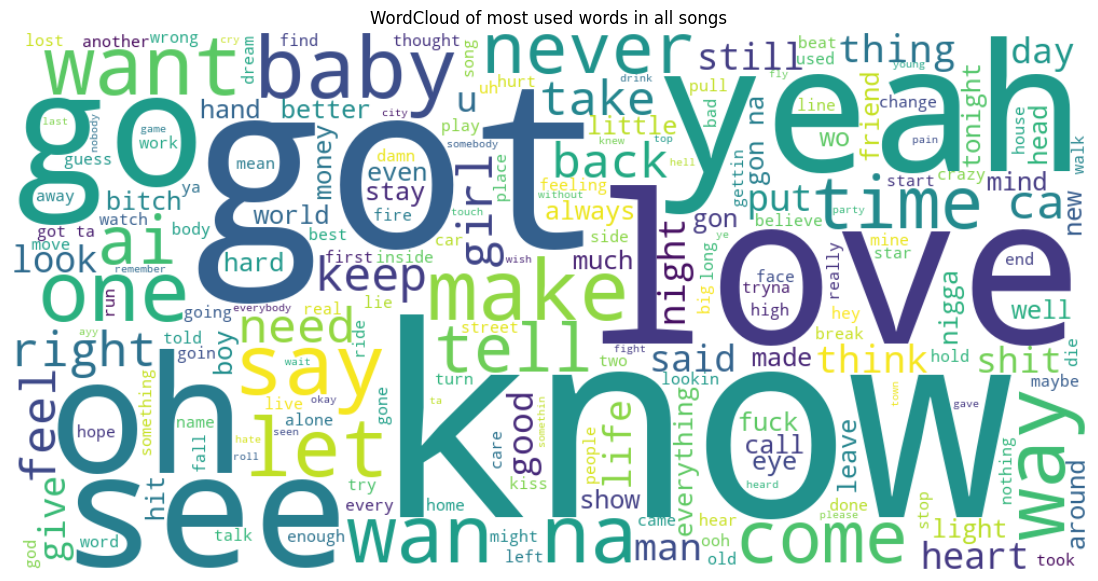

In [8]:
# Join all tokens for the WordCloud
all_text = " ".join(df["joined_tokens"])

# Generate and plot WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of most used words in all songs")
plt.show()


We selected Camila Cabello, Miley Cyrus, and Selena Gomez as we could conclude from our data analysis that they share the most songwriters. They are also among the most influential artists within a specific pop subgenre. Their prominence and commercial success make them representative figures for exploring the lyrical patterns and vocabulary commonly found in this part of the pop music landscape.

The purpose of this analysis is to investigate how language is used within the genre by comparing the artists’ lyrical styles. By applying TF-IDF (term frequency–inverse document frequency) to their lyrics, we can highlight the words that are most characteristic of each artist. This allows us to uncover the distinct themes, expressions, or stylistic choices that define their songwriting, and, more broadly, gain insight into the linguistic features that shape the genre as a whole.

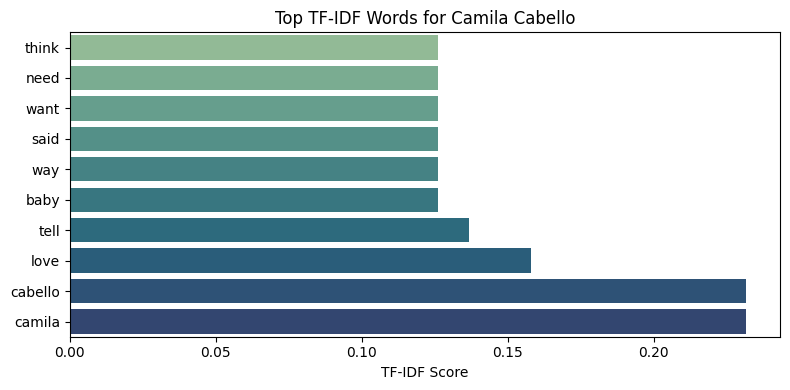

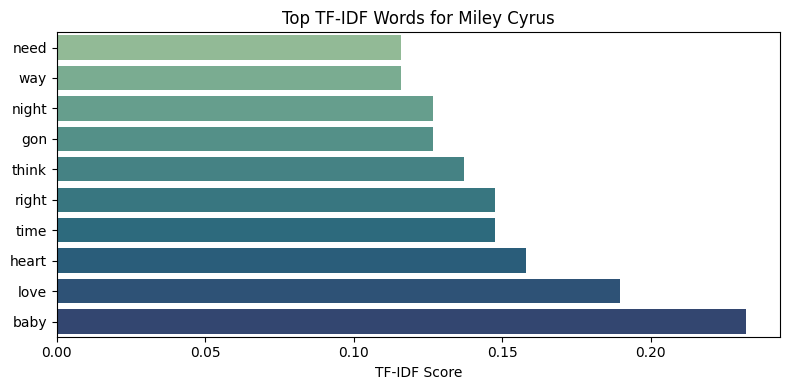

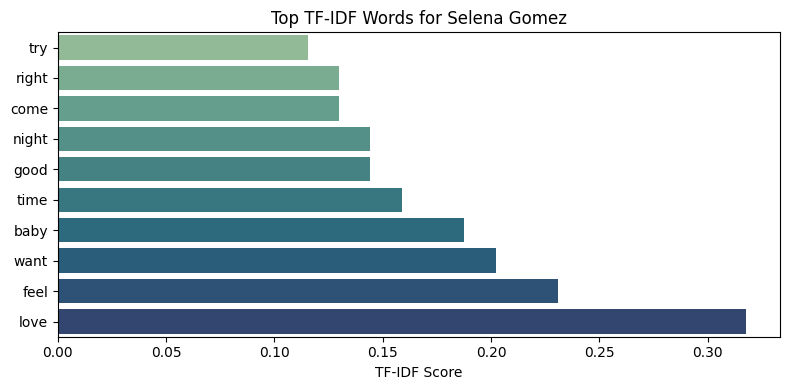

In [9]:
# Too many warnings showed...
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


# Only keeping songs by the three artists we want to compare
target_artists = ['camila cabello', 'miley cyrus', 'selena gomez']
filtered_df = df[df['Artist'].str.lower().isin(target_artists)]

# Making sure the tokens are in one long string per song
filtered_df["joined_tokens"] = filtered_df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Putting all songs from each artist into one big string per artist
artist_df = filtered_df.groupby("Artist")["joined_tokens"].apply(" ".join).reset_index()

# Some words just keep popping up and don’t say much — removing them manually
custom_stopwords = set([
    'yeah', 'na', 'oh', 'uh', 'ha', 'got', 'wan', 'ca', 'know', 'let', 'say', 'hey', 'like',
    'get', 'make', 'gonna', 'im', 'ill', 'aint', 'dont', 'youre', 'ive', 'could', 'would'
])

# Going through and taking those words out before doing TF-IDF
artist_df["filtered_tokens"] = artist_df["joined_tokens"].apply(
    lambda x: " ".join([word for word in x.split() if word not in custom_stopwords])
)

# Using TF-IDF to see which words are most "special" to each artist
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(artist_df["filtered_tokens"])
feature_names = vectorizer.get_feature_names_out()

# Plotting top 10 words per artist based on their TF-IDF score
for i, artist in enumerate(artist_df["Artist"]):
    row = tfidf_matrix[i].toarray().flatten()
    top_indices = np.argsort(row)[-10:]
    top_words = [feature_names[j] for j in top_indices]
    top_scores = [row[j] for j in top_indices]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_scores, y=top_words, palette="crest")
    plt.title(f"Top TF-IDF Words for {artist.title()}")
    plt.xlabel("TF-IDF Score")
    plt.tight_layout()
    plt.show()


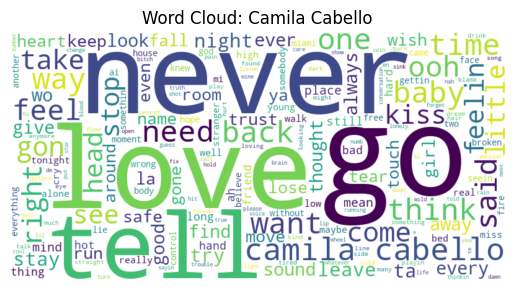

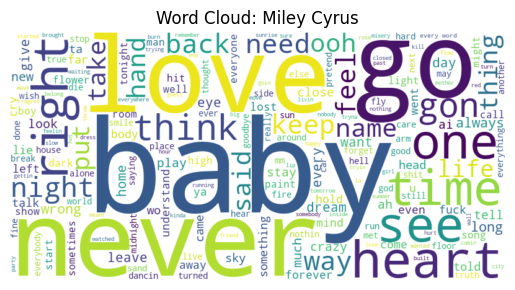

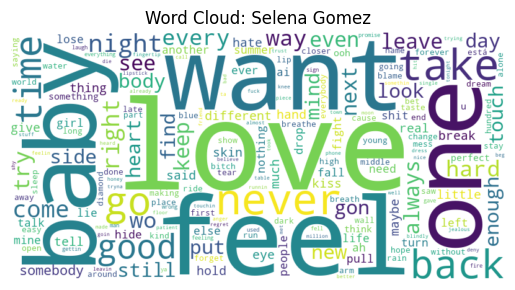

In [10]:
# Custom stopwords
custom_stopwords = set([
    'yeah', 'na', 'oh', 'uh', 'ha', 'got', 'wan', 'ca', 'know', 'let', 'say', 'hey', 'like',
    'get', 'make', 'gonna', 'im', 'ill', 'aint', 'dont', 'youre', 'ive', 'could', 'would'
])

# Define target artists (case-insensitive match)
target_artists = ['camila cabello', 'miley cyrus', 'selena gomez']
filtered_df = df[df['Artist'].str.lower().isin([a.lower() for a in target_artists])]

# Ensure joined_tokens exists (can be skipped if already present)
filtered_df["joined_tokens"] = filtered_df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Generate word clouds
for artist in target_artists:
    artist_rows = filtered_df[filtered_df['Artist'].str.lower() == artist]
    if artist_rows.empty:
        continue  # skip if artist has no songs
    text = " ".join(artist_rows["joined_tokens"])
    
    # Generate word cloud with custom stopwords
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate(text)
    
    # Plotting
    plt.figure(figsize=(6, 3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud: {artist.title()}")
    plt.tight_layout()
    plt.show()


Lyrics from Camila Cabello, Miley Cyrus, and Selena Gomez center on emotional introspection and themes of love, longing, and self-discovery. Words like “love,” “baby,” “never,” and “feel” dominate, painting a picture of vulnerability and personal relationships. The tone is expressive and reflective, often focused on romantic experiences and the complexities of the heart. Even in upbeat songs, there’s a consistent emotional undercurrent that highlights personal connection and self-worth.


Another group that emerged from the datanalysis was Travis Scott, Cardi B, Nicki Minaj, Drake, Meek Mill who are lean more towards the rap genre. The same analysis was done for them: 

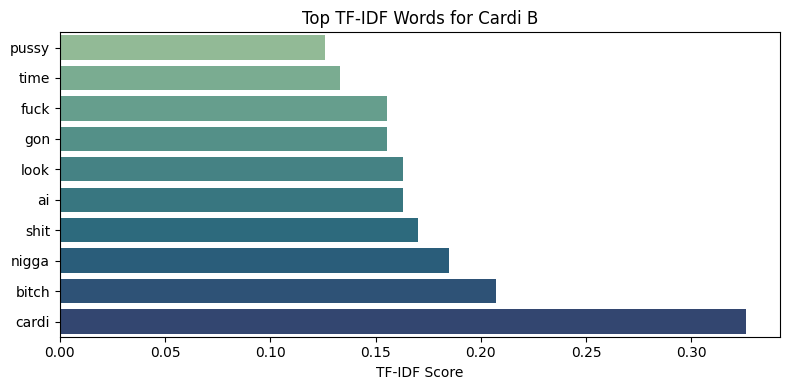

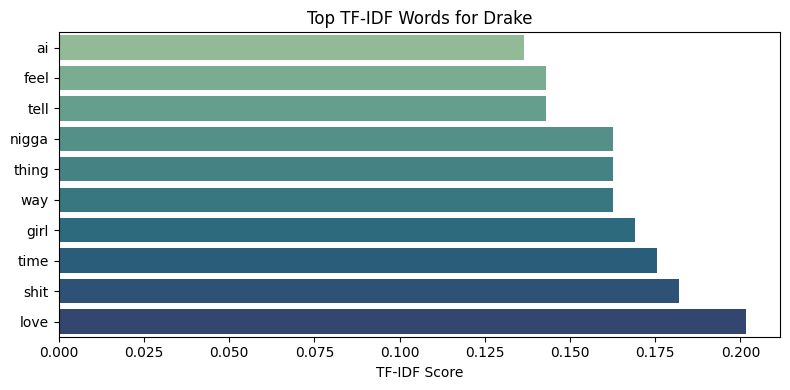

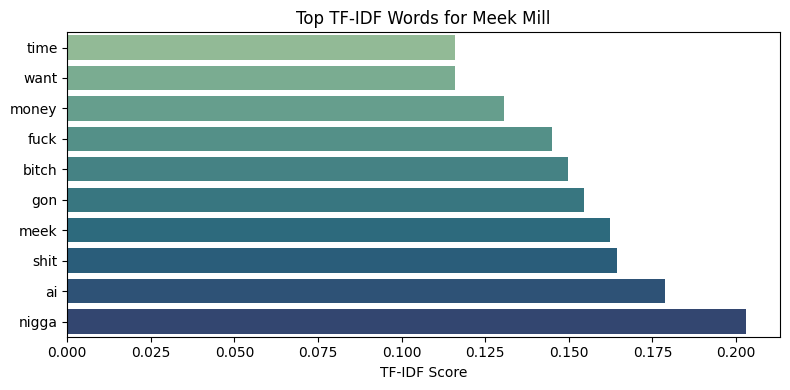

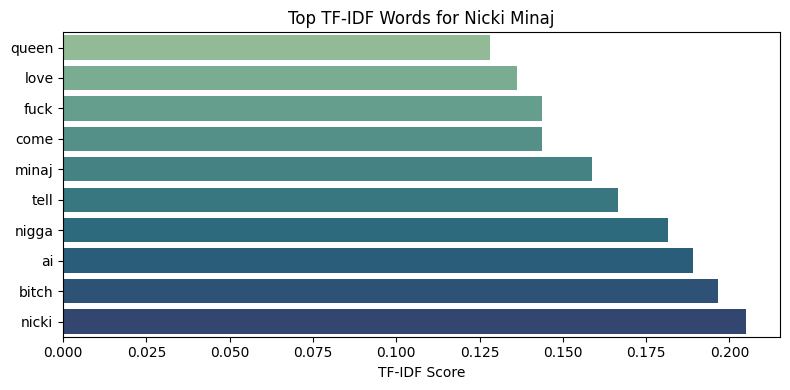

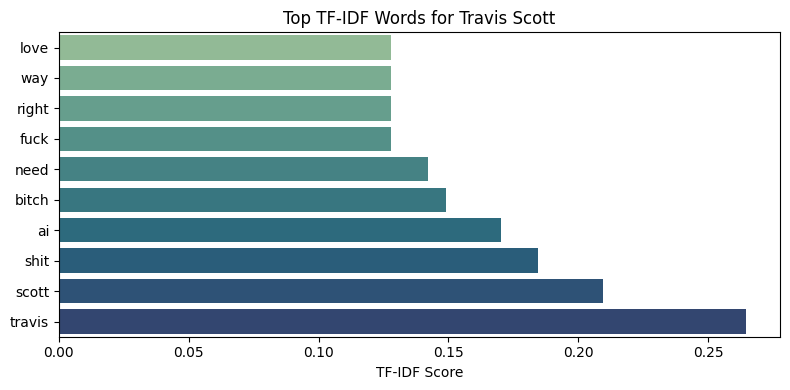

In [11]:
# Too many warnings showed...
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


# Only keeping songs by the three artists we want to compare
target_artists = ['travis scott', 'cardi b', 'nicki minaj', 'drake', 'meek mill']
filtered_df = df[df['Artist'].str.lower().isin(target_artists)]

# Making sure the tokens are in one long string per song
filtered_df["joined_tokens"] = filtered_df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Putting all songs from each artist into one big string per artist
artist_df = filtered_df.groupby("Artist")["joined_tokens"].apply(" ".join).reset_index()

# Some words just keep popping up and don’t say much — removing them manually
custom_stopwords = set([
    'yeah', 'na', 'oh', 'uh', 'ha', 'got', 'wan', 'ca', 'know', 'let', 'say', 'hey', 'like',
    'get', 'make', 'gonna', 'im', 'ill', 'aint', 'dont', 'youre', 'ive', 'could', 'would'
])

# Going through and taking those words out before doing TF-IDF
artist_df["filtered_tokens"] = artist_df["joined_tokens"].apply(
    lambda x: " ".join([word for word in x.split() if word not in custom_stopwords])
)

# Using TF-IDF to see which words are most "special" to each artist
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(artist_df["filtered_tokens"])
feature_names = vectorizer.get_feature_names_out()

# Plotting top 10 words per artist based on their TF-IDF score
for i, artist in enumerate(artist_df["Artist"]):
    row = tfidf_matrix[i].toarray().flatten()
    top_indices = np.argsort(row)[-10:]
    top_words = [feature_names[j] for j in top_indices]
    top_scores = [row[j] for j in top_indices]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_scores, y=top_words, palette="crest")
    plt.title(f"Top TF-IDF Words for {artist.title()}")
    plt.xlabel("TF-IDF Score")
    plt.tight_layout()
    plt.show()


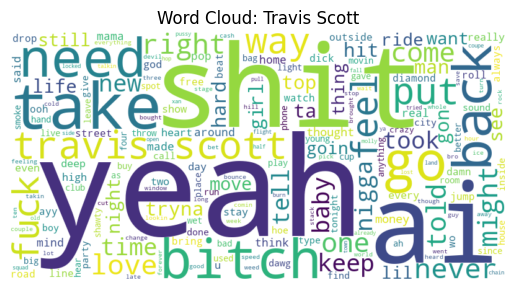

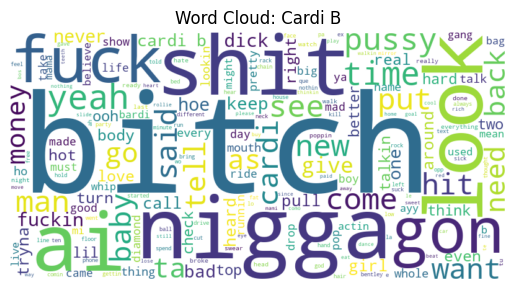

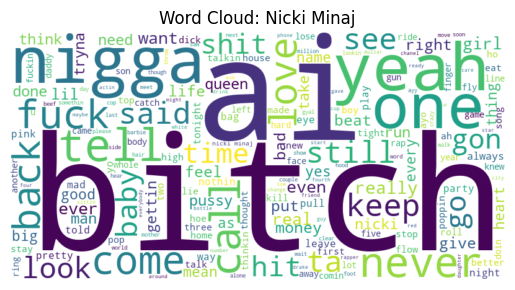

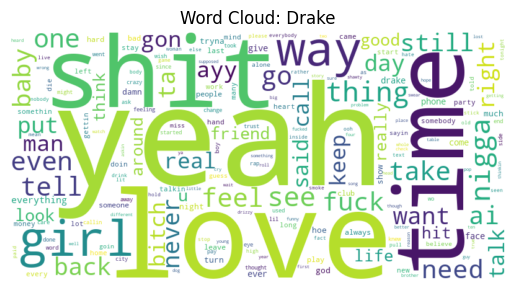

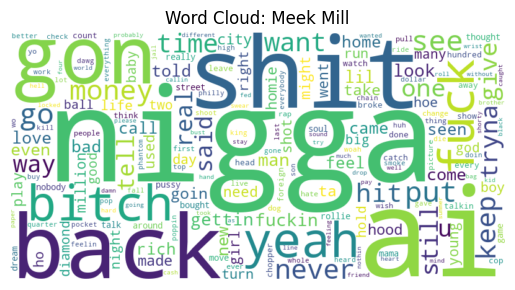

In [12]:
# Custom stopwords
custom_stopwords = set([
    'na', 'oh', 'uh', 'ha', 'got', 'wan', 'ca', 'know', 'let', 'say', 'like',
    'get', 'make', 'gonna', 'im', 'ill', 'aint', 'dont', 'youre', 'ive', 'could', 'would'
])

# Define target artists (case-insensitive match)
target_artists = ['travis scott', 'cardi b', 'nicki minaj', 'drake', 'meek mill']
filtered_df = df[df['Artist'].str.lower().isin([a.lower() for a in target_artists])]

# Ensure joined_tokens exists (can be skipped if already present)
filtered_df["joined_tokens"] = filtered_df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Generate word clouds
for artist in target_artists:
    artist_rows = filtered_df[filtered_df['Artist'].str.lower() == artist]
    if artist_rows.empty:
        continue  # skip if artist has no songs
    text = " ".join(artist_rows["joined_tokens"])
    
    # Generate word cloud with stopwords
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate(text)
    
    # Display
    plt.figure(figsize=(6, 3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud: {artist.title()}")
    plt.tight_layout()
    plt.show()


Lyrics from Travis Scott, Cardi B, Nicki Minaj, Drake, and Meek Mill are more assertive and raw, often laced with slang, profanity, and street vernacular. Words like “bitch,” “fuck,” “shit,” and “yeah” are prominent, reflecting themes of dominance, wealth, struggle, and identity. These lyrics emphasize power, confidence, and survival, frequently addressing external realities more than inner feelings. The energy is bold and unfiltered, mirroring the culture of competition and performance.


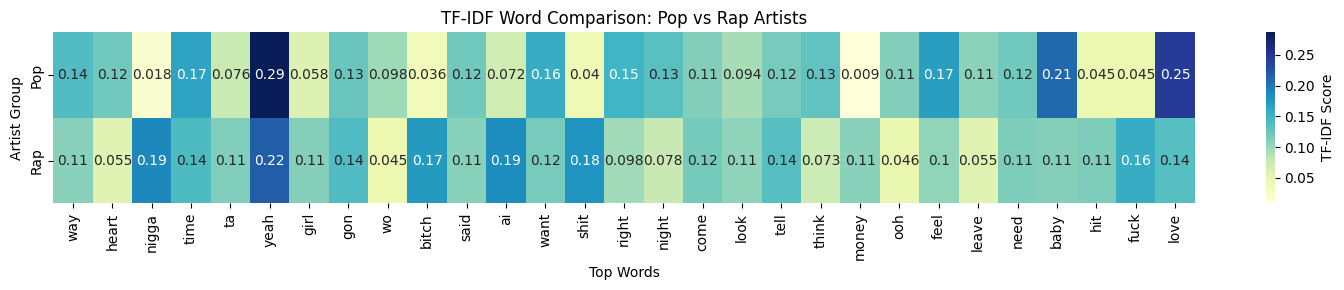

In [21]:
# Custom stopwords
custom_stopwords = set([
    'na', 'oh', 'uh', 'ha', 'got', 'wan', 'ca', 'know', 'let', 'say', 'like',
    'get', 'make', 'gonna', 'im', 'ill', 'aint', 'dont', 'youre', 'ive', 'could', 'would'
])

# Combine and convert to list
combined_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

# Defining artist groups
pop_artists = ['camila cabello', 'miley cyrus', 'selena gomez']
rap_artists = ['travis scott', 'cardi b', 'nicki minaj', 'drake', 'meek mill']

# Make sure tokens are joined
df["joined_tokens"] = df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Combine lyrics by group
group_texts = {
    "Pop": " ".join(df[df['Artist'].str.lower().isin(pop_artists)]["joined_tokens"]),
    "Rap": " ".join(df[df['Artist'].str.lower().isin(rap_artists)]["joined_tokens"]),
}

# Compute TF-IDF
vectorizer = TfidfVectorizer(max_features=2000, stop_words=combined_stopwords)
tfidf_matrix = vectorizer.fit_transform(group_texts.values())
feature_names = vectorizer.get_feature_names_out()

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=group_texts.keys(), columns=feature_names)

# Get top N terms per group (or union of top N from both)
top_n = 20
top_pop = tfidf_df.loc["Pop"].sort_values(ascending=False).head(top_n)
top_rap = tfidf_df.loc["Rap"].sort_values(ascending=False).head(top_n)
top_words = list(set(top_pop.index).union(set(top_rap.index)))

# Filter DataFrame to these words
heatmap_df = tfidf_df[top_words]

# Plot heatmap
plt.figure(figsize=(15, 3))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", cbar_kws={"label": "TF-IDF Score"})
plt.title("TF-IDF Word Comparison: Pop vs Rap Artists")
plt.xlabel("Top Words")
plt.ylabel("Artist Group")
plt.tight_layout()
plt.show()


The image above shows a TF-IDF heatmap of the lyrical difference between two of the genre artists: pop and rap. Pop lyrics continue to emphasize emotional language, with higher TF-IDF scores for words like love, baby, feel, and leave, reflecting vulnerability, relationships, and inner conflict. In contrast, rap lyrics lean heavily on assertive and explicit terms— fuck, shit, and bitch—that convey power, confrontation, and social realism. The word yeah also appears prominently in rap, mirroring the genre's rhythmic and performative flow. While some shared terms like time and need surface in both, their usage likely diverges in tone and intent, further highlighting how each genre constructs meaning through distinct vocabularies.


c:\Users\celin\miniconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


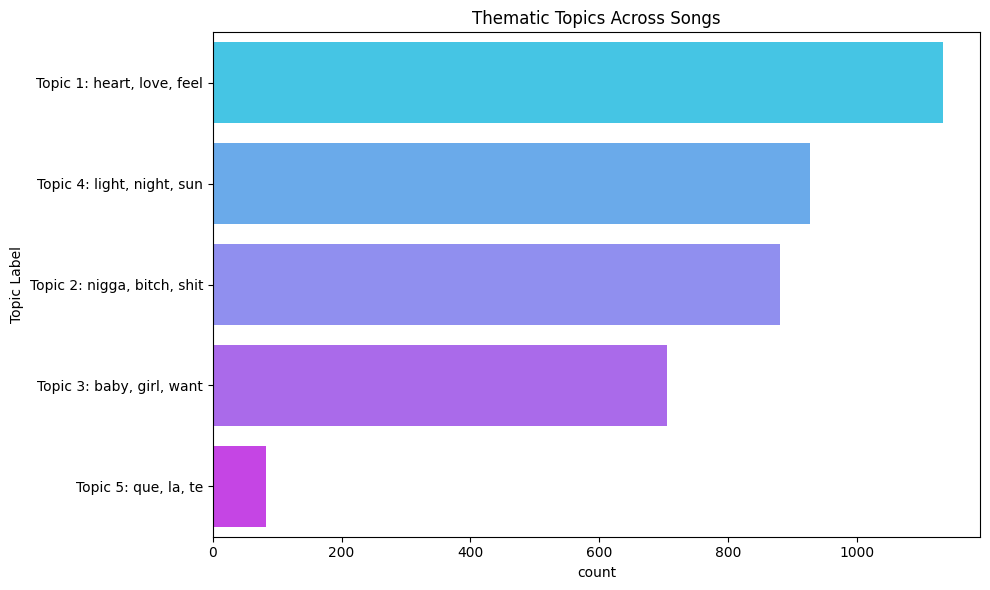

In [15]:
# Just keeping things quiet
warnings.simplefilter(action='ignore', category=FutureWarning)

# Some words just keep popping up and don’t say much — removing them manually
custom_stopwords = set([
    'yeah', 'na', 'oh', 'uh', 'ha', 'got', 'wan', 'ca', 'know', 'let', 'say', 'hey', 'like',
    'get', 'make', 'gonna', 'im', 'ill', 'aint', 'dont', 'youre', 'ive', 'could', 'would'
])

# Making sure the tokens are joined (if not already)
df["joined_tokens"] = df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Remove custom stopwords from the joined lyrics
df["filtered_lyrics"] = df["joined_tokens"].apply(
    lambda x: " ".join([word for word in x.split() if word not in custom_stopwords])
)

# TF-IDF vectorization (per song, after removing common junk words)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf = vectorizer.fit_transform(df["filtered_lyrics"])

# Applying NMF to find common themes in the lyrics
nmf = NMF(n_components=5, random_state=42)
nmf_features = nmf.fit_transform(tfidf)

# Extract the top 10 words per topic
feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_weights in nmf.components_:
    top_words = [feature_names[i] for i in topic_weights.argsort()[-10:][::-1]]
    topics.append(top_words)

# Assign each song to the topic it most strongly relates to
df['Topic'] = nmf_features.argmax(axis=1)
df['Topic Label'] = df['Topic'].apply(lambda x: f"Topic {x+1}: " + ", ".join(topics[x][:3]))

# Visualizing how many songs belong to each topic
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Topic Label', order=df['Topic Label'].value_counts().index, palette="cool")
plt.title("Thematic Topics Across Songs")
plt.tight_layout()
plt.show()


The chart highlights the most common thematic topics found dataset. The most dominant topic—centered around heart, love, and feel—shows that emotional and romantic themes continue to be a powerful driver of popular music. This aligns with the idea that universally relatable feelings are a key factor in a song’s mass appeal.

 
Other prominent topics, such as light, night, sun (Topic 4), suggest that imagery and mood-setting also play a significant role in songwriting for popular tracks. Meanwhile, the prevalence of more explicit and aggressive language (bitch, shit in Topic 2) reflects the rise and influence of rap and hip-hop in the mainstream, especially among the top artists of the decade.


Finally, the topic distribution suggests that the most successful songs blend emotional resonance, catchy or atmospheric language, and bold expressions of identity. These lyrical strategies help explain why certain songs and themes dominate popular charts and continue to connect with wide audiences.


--------------------------------

# **Discussion**

#### What went well?


We were able to uncover a lot of the structure behind the music industry and draw conclusions based on insights and evidence. The networks revealed that while there might not be a huge network structure there still exists a central base of songwriters supporting the top artists by aiding on their songs. The graphs also revealed a big tendency for artists to generally use songwriters a lot on their songs and also for them to have a personal team of songwriters around them. Here it could be seen that many songwriters only had one link in the graph connecting them to a singular artist and from the song graph we could see that they furthermore also only contributed to a single song for that artist. 

We successfully looked into the top 10 songwriters that were central for this graph to determine how many they collaborate with and how often. We looked at their influence throughout the year were several of them were names that had been presented for a long time all the way back to the start 2000's while others were more new but already had a big influence as seen by their popularity score and the amount of unique top artists they already had collaborated with. 

Lastly we could use the data-analysis to determine communities of artists who had a tendence to both use a lot of songwriters and also shared a lot of songwriters and extract to interesting communties, which represented the genres pop and rap. We conducted lyrical analysis on these artists genres to look for similarities both inside the communities and to compare the difference in lyrical content between the communties. 

#### What is still missing? What could be improved? Why?

Several improvements could enhance the depth and accuracy of the analysis. First, the data retrieval and cleaning process still has inconsistencies as some song titles continued to include featured artists, which may have skewed the amount of songs, because it allows for duplicates. This could give some songwriters more influence as they would appear more often. An even more thorough walk through and examination would improve and fix this problem, but it was not possible to do this round due to time constraints. 

Expanding the dataset to include more songs and artists beyond the current top 100 could potentially provide a broader perspective and help identify influential songwriters operating outside this elite group. Including songs written by the top songwriters for artists not in the top 100 could uncover more hidden connections within the industry and might also reveal connections between the current group of songwriters, which are just not captured in the songs we have included. 

Finally, there is a noticeable imbalance between the number of songs, songwriters, and artists, which means that the current scope may be too narrow to fully capture the network’s complexity. Adding the songwriters other credited songs could potentially reveal a more complex connection between songwriters than the one uncovered here. Most of the conclusion for this network would still stand and represent one area of the music industry even if we were to expand the network as it reflects the production for the songs we have included. Expanding on the datasets size might reveal other areas and would allow us to expand on our current conclusion. 
